# Analysis of Large MERFISH Data

**Date:** 2020-08-15<br>
**Data:** MERFISH large dataset : <br>
**Description:** Application of the descriptive statistics to a larger dataset, to assess general trends across multiple samples. Three main features will be analyzed:<br>
* Univariate Ripley's K
* Bivariate Ripley's K
* PCF (Pair Correlation Function)


## Load Libraries

We will be using some custom modules to reduce the amount of code in the notebook, namely: `spatstat`, `datasets` and `utils`.

In [1]:
%load_ext Cython
%load_ext autoreload
%autoreload 2

In [2]:
import spatstat as sp
import datasets
import utils as ut

import anndata as ad
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os.path as osp
import os

## Load and Prepare Data

First set some global variables to make things easier for us

In [3]:
DATA_PTH = '/home/alma/w-projects/stx/data/MERFISH_MOp_MERFISH_MOp_0502.h5ad'
OUT_DIR_UNI = "/tmp/ripk_uni"
OUT_DIR_MUL = "/tmp/ripk_mul"
OUT_DIR_PCF = "/tmp/pcf"

Inspect the data to make sure everything looks allright

In [4]:
all_data = ad.read_h5ad(DATA_PTH)
all_data.obs

,volume,x,y,AP_distance,soma_depth,label,subclass,class_label,specimen_id,batch_id,slice
index,,,,,,,,,,,
10000143038275111136124942858811168393,992.830060,4738.397298,3075.327399,400.0,959.227100,Astro_1,Astrocytes,Other,2,4,31
100001798412490480358118871918100400402,610.091871,-3964.711404,1451.889047,1690.0,1246.938980,Endo,Endothelial,Other,2,5,160
100006878605830627922364612565348097824,148.277718,805.843523,1215.035473,1180.0,7.369782,SMC,SMC,Other,2,6,109
100007228202835962319771548915451072492,249.515471,1348.686198,-3589.955255,700.0,1123.956211,Endo,Endothelial,Other,1,2,71
100009332472089331948140672873134747603,1779.831996,-3584.650904,-1883.105955,2280.0,324.069916,L23_IT_3,L23_IT,Glutamatergic,2,5,219
...,...,...,...,...,...,...,...,...,...,...,...
99987465505639073211021560543065098772,1208.963097,890.666985,1069.905972,2500.0,198.887653,Pvalb_1,Pvalb,GABAergic,1,5,251
99989592830367590092304100078674096866,611.167089,1913.334949,1280.947292,2700.0,772.996776,L5_PT_5,L5_PT,Glutamatergic,2,3,261
99991756591196613545069880666241120777,130.928366,3847.387896,3589.662245,1110.0,623.739723,L45_IT_4,L45_IT,Glutamatergic,1,3,112


Extract cells from the same datasets, for each subset extraction will be done based on:

* specimen id - only cells from the same specimen should be used 
* batch id - ensure cells come from the same batch
* slice - ensure cells comre from the same slice

all data will be stored as `MerfishData` objects in the `data` dictionary, keys are `[batch_id]_[slice]`.

we will use the `subclass` types in our analysis, to change this simply modify the definition of the `type_colname` variable.

_comment_ : it seems as if batch id is redundant for unique selection, slice id's would be enough to get the same results. Have not confirmed yet.

In [5]:
type_colname = "subclass"
data = dict()
ids = list()
mask_1 = all_data.obs["specimen_id"].values == 1

for batch_id in all_data.obs["batch_id"].unique():
    mask_2 = all_data.obs["batch_id"] == batch_id
    slice_ids = all_data.obs[mask_1 & mask_2].slice.unique()
    for slice_id in slice_ids:
        ids.append([batch_id, slice_id])

for batch,slice_id in ids:
    
    mask_2 = all_data.obs["batch_id"].values == batch
    mask_3 = all_data.obs["slice"].values == slice_id
    
    _subset = all_data[mask_1 & mask_2 & mask_3]
    data.update({"{}_{}".format(batch,slice_id):datasets.MerfishData(data = _subset,
                                                                    type_colname= type_colname)})


Inspect one sample and check whether the computed edge distances (used in edge correction) makes sense. First sample in the data set will be used for visualization.

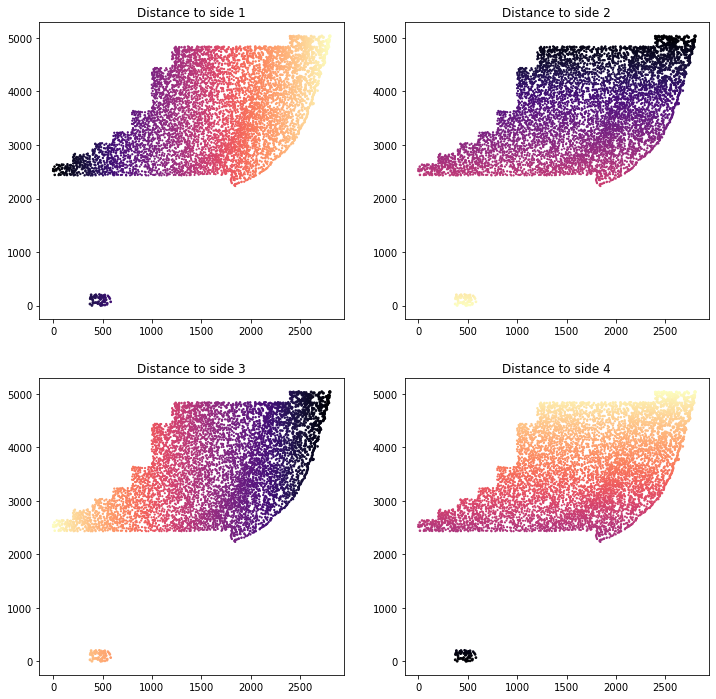

In [6]:
firstkey = list(data.keys())[0]
edgedistances = data[firstkey]._get_edgedistances()

fig,ax = plt.subplots(2,2,figsize = (12,12))
ws = data[firstkey].weights(1200)
ax = ax.flatten()
for k in range(4):
    
    ax[k].scatter(data[firstkey].crd[:,0],
                  data[firstkey].crd[:,1],
                  c = edgedistances[:,k],
                  cmap = plt.cm.magma,
                  s = ws / ws.max() * 5,
                 )
    ax[k].set_title("Distance to side {}".format(k+1))
    
plt.show()

## Analysis

### Univariate Ripley's K : Compuations

We'll compute $K_{uni}(t)$ for all sections and store the results in `OUT_DIR_UNI`. We will generate results where edge correction (tagged with `EC`) is respectively is not present (tagged with `OR`). 

The edge correction only supports distances that are at most half the length of the shortest side of the bounding box, hence we set the upper bound to half the shortest length among all samples.

`n_steps` different distances between $[0,\textrm{upper_bound}]$ will be analyzed. 

We will save each results to a `.tsv` file, to ensure these are kept (in case of a crashed notebook etc., since these take quite some time to compute).

Set the variable `save` to `True` to save the results, a safety measure to avoid accidentally overwriting old results. 

In [ ]:
save = False

upper_bound = np.min([d.minside for d in data.values()])
upper_bound /= 2

n_steps = 500

radii = np.linspace(0,upper_bound,n_steps)

for nd,(sample,d) in enumerate(data.items()):
    
    
    res_ec = dict()
    res_or = dict()
    
    for nt,ct in enumerate(d.uni_types):
        
        print("Sample {}/{} | Type {}/{}"\
              .format(nd,len(data),nt,len(d.uni_types)))
        
        sel = d.types == ct
        
        rKs_ec = list()
        rKs_or = list()
        
        for radius in radii:
            ws = d.weights(radius)[sel]
            
            _rK_ec = K_uni(t = radius,
                           crd = d.crd[sel],
                           A = d.area,
                           ws = ws)
            
            _rK_or = K_uni(t = radius,
                           crd = d.crd[sel],
                           A = d.area,
                           ws = np.ones(len(ws)))
            
            rKs_ec.append(_rK_ec)
            rKs_or.append(_rK_or)
    
        res_ec.update({ct:rKs_ec})
        res_or.update({ct:rKs_or})
    
    res_ec = pd.DataFrame(res_ec,
                          index = pd.Index(radii))
    res_or = pd.DataFrame(res_or,
                          index = pd.Index(radii))
    
    
    if save:
        basename = sample + "-#" + ".tsv"
        res_ec.to_csv(osp.join(OUT_DIR_UNI,basename.replace("#","EC")),
                      sep = '\t')
        res_or.to_csv(osp.join(OUT_DIR_UNI,basename.replace("#","OR")),
                      sep = '\t')
    else:
        print("NOTE: RESULTS ARE NOT SAVED")
    

Load the results for the Ripley's K analysis. For this we use the `load_results` function, while the `merge_results` function puts all the results in a single `[n_samples]x[n_distances]x[n_types]` tensor.

`load_function` will adjust results file such that columns and rows agree, ~~if a cell type is not present in one sample zeros will be added for all distances~~ only cell type combinations present in all samples are loaded here.

In [7]:
# add a filter to only look at the results where edge correction
# was used. Change EC--> OR for the opposite.

use_edgecorrection = lambda x: "-EC" in x

results,columns,indices = ut.load_results(dirname = OUT_DIR_UNI,
                                       filters = use_edgecorrection,
                                      )


results_tensor = ut.merge_results(results,
                                  columns,
                                  indices)

Generate data frames from the tensor, one containing the means and one the standard deviations.

In [8]:
results_mu = pd.DataFrame(results_tensor.mean(axis = 0),
                          index = indices,
                          columns = columns,
                         )

results_sd = pd.DataFrame(results_tensor.std(axis = 0),
                          index = indices,
                          columns = columns,
                         )


### Univariate Ripley's K : Visualization 
Visualize the results, by plotting the $K_{uni}(r)$ values against the radius, values for a CSR is included as a reference.

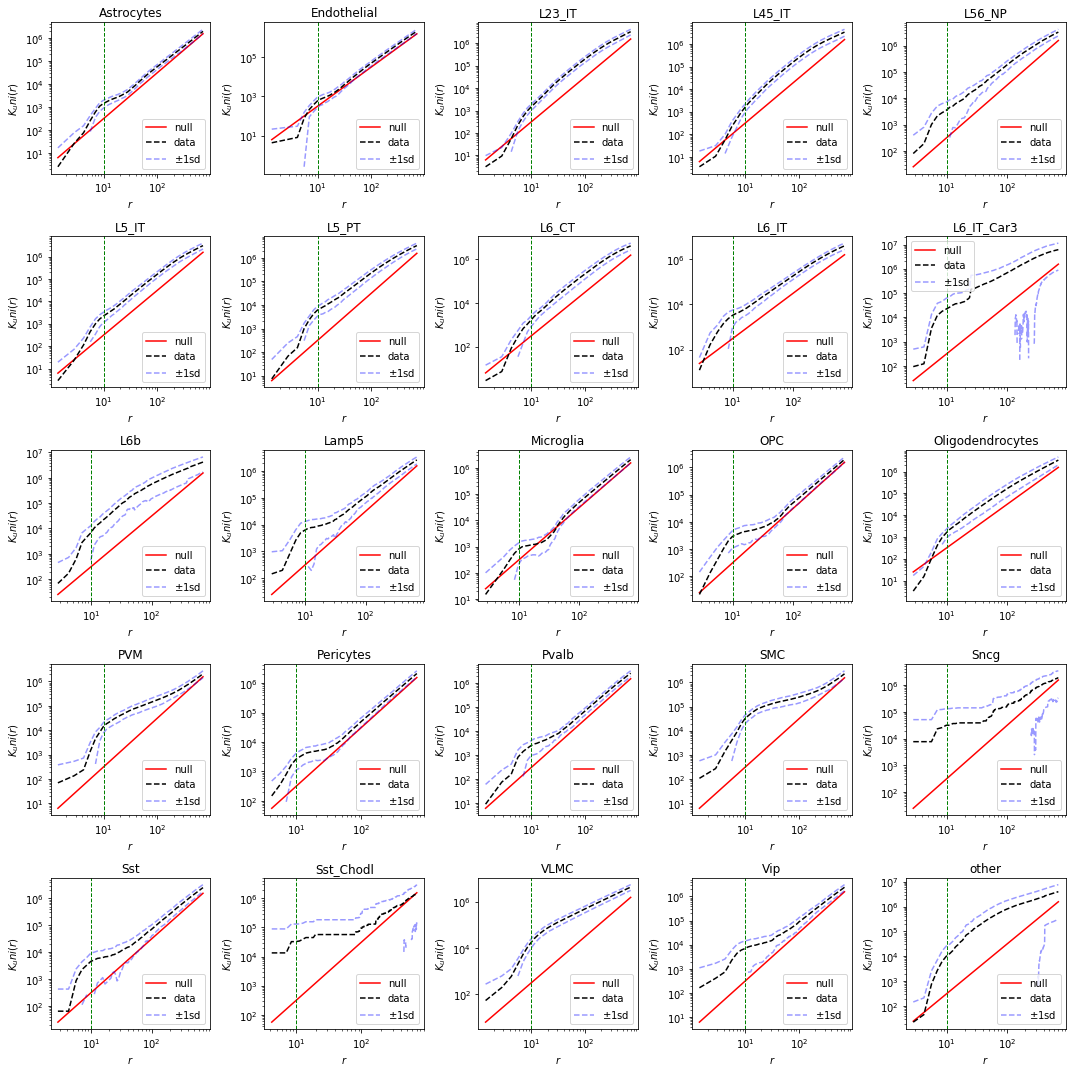

In [11]:
n_cols = 5
n_rows = int(np.ceil(len(columns) / n_cols))

ref_dist = 10

radii = results_mu.index.values

figsize = (n_cols * 3, n_rows * 3)

fig,ax = plt.subplots(n_cols,n_rows, figsize = figsize)
ax = ax.flatten()

theo = np.array([np.pi*(d**2) for d in radii])

for k,ct in enumerate(results_mu.columns.values):

    nz = results_mu[ct].values > 0

    ut.plot_results(ax[k],
                    x_vals = radii[nz],
                    obs = results_mu[ct].values[nz],
                    std = results_sd[ct].values[nz],
                    theo = theo[nz],
                    vertical_reference = 10,
                    )

    ax[k].set_title(ct)
    ax[k].set_xlabel(r"$r$")
    ax[k].set_ylabel(r"$K_uni(r)$")

    
fig.tight_layout()
plt.show()

Next, we can inspect certain cell types to see if the results above resonate with the distribution we observe. We use the `visualize_types` function from the `utils` module for this.

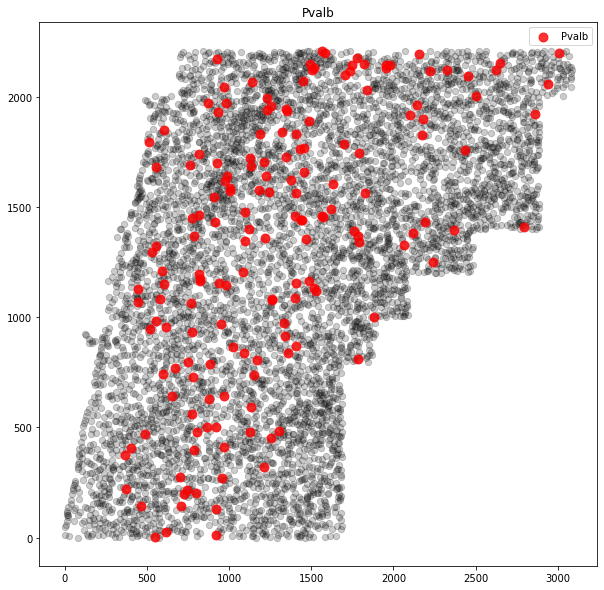

In [12]:
visualize_type = "Pvalb"
visualize_sample = 4

fk = list(data.keys())[visualize_sample]
crd = data[fk].crd

fig,ax = plt.subplots(1,1,figsize = (10,10))

ut.visualize_types(ax,
                  crd,
                  labels = data[fk].types,
                  selected = visualize_type,
                  cmap = "one_two",
                 )

ax.set_title(visualize_type)

plt.show()

### Bivariate Ripley's K : Computation

Similar to the univariate form, but here we use:

\begin{equation}
K_{bi}(r) = \frac{A}{n_1 n_2}\sum_{i=1}^{n_2}w_i\sum_{j=1}^{n_1} I_r(x_i,x_j)
\end{equation}

Where summation over $i$ and $j$ occurs over different cell types. Note that $K_{bi}(r)$ is _not_ symmetric, when weights for edge correction are used in the scheme.

Here we only compute results when edge correction is implemented.


In [ ]:
save = False

upper_bound = np.min([d.minside for d in data.values()])
upper_bound /= 2

radii = np.exp(np.linspace(0,np.log(upper_bound),100))

for nd,(sample,d) in enumerate(data.items()):
    
    
    res_ec = dict()
    
    for nt1,ct1 in enumerate(d.uni_types):
        for nt2,ct2 in enumerate(d.uni_types):
            if ct2 == ct1: 
                continue
                
            print("Sample {}/{} | Pair {}/{} "\
                  .format(nd+1,len(data),(nt1*len(d.uni_types)) +\
                          nt2 + 1,len(d.uni_types)**2))

            sel1 = d.types == ct1
            sel2 = d.types == ct2

            rKs_ec = list()

            for radius in radii:
                ws = d.weights(radius)[sel1]

                _rK_ec = sp.K_mul(t = radius,
                               crd1 = d.crd[sel1,:],
                               crd2 = d.crd[sel2,:],
                               A = d.area,
                               ws = ws)

                rKs_ec.append(_rK_ec)

            res_ec.update({ct1 + "_" + ct2:rKs_ec})

    res_ec = pd.DataFrame(res_ec,index = pd.Index(radii))

    if save:
        basename = sample + "-#" + ".tsv"
        res_ec.to_csv(osp.join(OUT_DIR_MUL,basename.replace("#","EC")),sep = '\t')

Load the generated results and compute mean as well as standard deviations.

In [27]:


results,columns,indices = ut.load_results(dirname = OUT_DIR_MUL,
                                      )

results_tensor = ut.merge_results(results,
                                  columns,
                                  indices)

results_mu = pd.DataFrame(results_tensor.mean(axis = 0),
                          index = indices,
                          columns = columns,
                         )

results_sd = pd.DataFrame(results_tensor.std(axis = 0),
                          index = indices,
                          columns = columns,
                         )


### Bivariate Ripley's K : Visualization

Similarly to the univariate case, we first look at $K_{bi}(t)$ as a function of the radius ($r$). Since there number of cell type combinations is high and we don't want to plot every single one one of them, we randomly select 25 pairs to visualize our results.

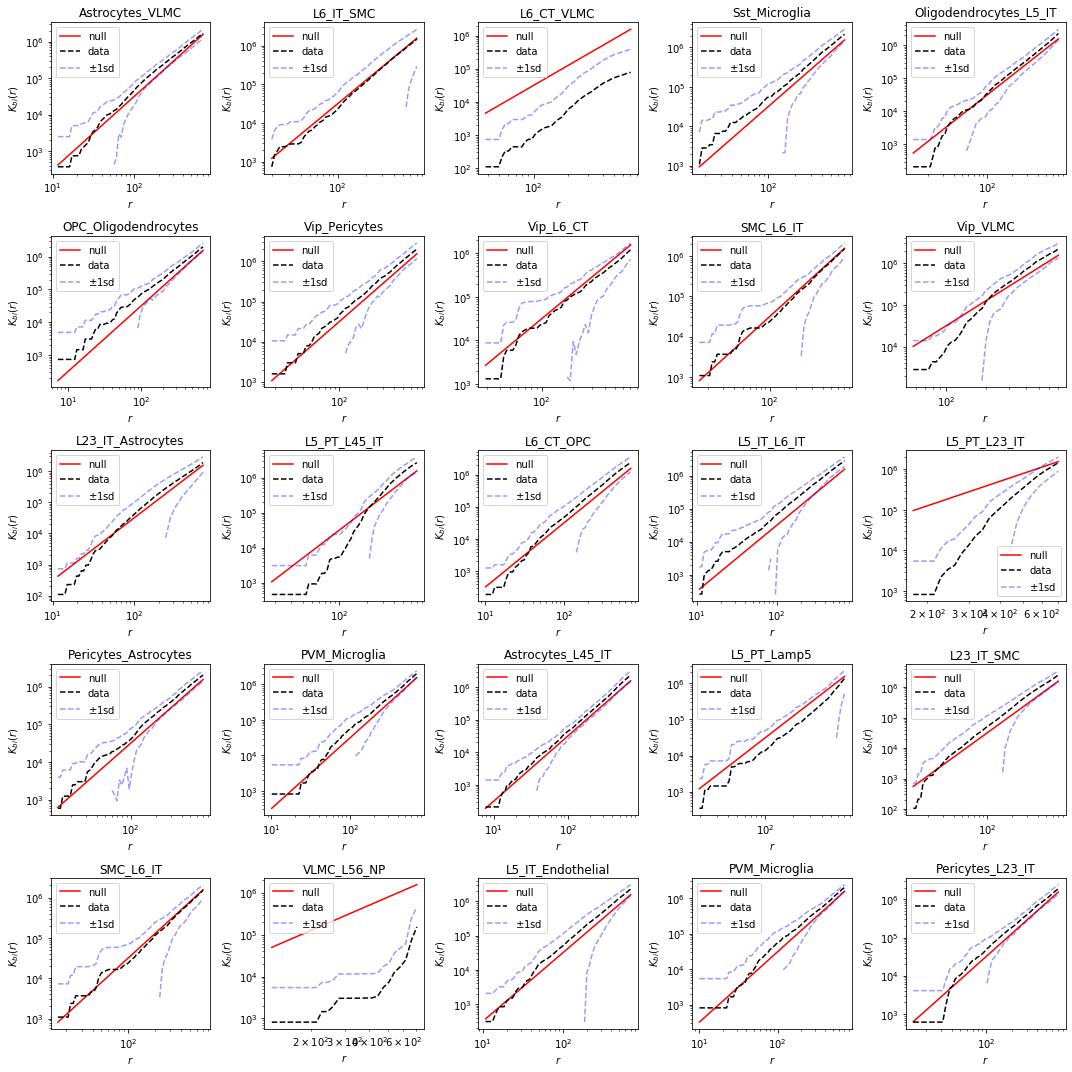

In [28]:
n_show = 25
n_cols = 5
n_rows = int(np.ceil(n_show / n_cols))

ref_dist = 100

radii = results_mu.index.values

figsize = (n_cols * 3,
           n_rows * 3)

fig,ax = plt.subplots(n_cols,n_rows, figsize = figsize)
ax = ax.flatten()

theo = np.array([np.pi*(d**2) for d in radii])

cell_types = np.random.choice(results_mu.columns,n_show)

for k,ct in enumerate(cell_types):

    nz = results_mu[ct].values > 0

    ut.plot_results(ax[k],
                    x_vals = radii[nz],
                    obs = results_mu[ct].values[nz],
                    std = results_sd[ct].values[nz],
                    theo = theo[nz],
                    )

    ax[k].set_title(ct)

    ax[k].legend()
    ax[k].set_xlabel(r"$r$")
    ax[k].set_ylabel(r"$K_{bi}(r)$")

    
fig.tight_layout()
plt.show()

Again, as for the univariate case we can visualize the actual distribution of our types in a sample - the same function as before can be used for this.

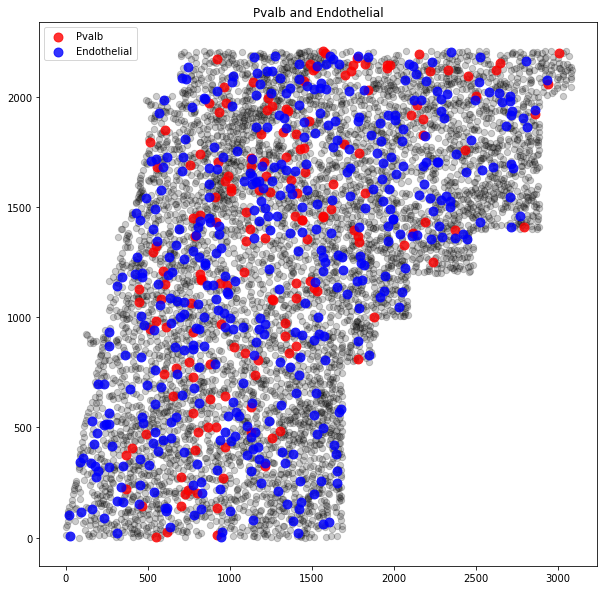

In [58]:
visualize_type_1 = "Pvalb"
visualize_type_2 = "Endothelial"
visualize_sample = 4


selected = [visualize_type_1,visualize_type_2]
fk = list(data.keys())[visualize_sample]

crd = data[fk].crd

fig,ax = plt.subplots(1,1,figsize = (10,10))

ut.visualize_types(ax,
                  crd,
                  labels = data[fk].types,
                  selected = selected,
                  cmap = "one_two",
                 )
ax.set_title("{} and {}".format(visualize_type_1,
                                visualize_type_2))

plt.show()

### PCF : Computation 

Next, we look at the Pair Correlation Function (PCF), just as for the bivariate case we will look at all pairs of cell types. The PCF, in contrast to Ripley's K, uses an _annulus_ as a search region - this reduces the risk for signals at short distances to interfere with those observed at larger distances. However, it also requires that a `bandwidth` is set, which determines the shape of the annulus. In other words, the bandwidth dictates how broad the region around a specified search radius should be - see image below:

<img src="img/annulus.png">

In [17]:
save = True
bandwidth = 20
upper_bound = np.min([d.minside for d in data.values()])
upper_bound /= 2

radii = np.linspace(2*bandwidth,upper_bound-bandwidth,250)

for nd,(sample,d) in enumerate(data.items()):
    
    res_pcf = dict()
    
    for nt1,ct1 in enumerate(d.uni_types):
        for nt2,ct2 in enumerate(d.uni_types):
            if ct2 == ct1: 
                continue
                
            print("Sample {}/{} | Pair {}/{} "\
                  .format(nd+1,len(data),(nt1*len(d.uni_types)) +\
                          nt2 + 1,len(d.uni_types)**2))

            sel1 = d.types == ct1
            sel2 = d.types == ct2

            pcfs = list()

            for radius in radii:
                _pcf = sp.PCF_r(r = radius,
                                crd1 = d.crd[sel1,:],
                                crd2 = d.crd[sel2,:],
                                A = d.area,
                                h = bandwidth,
                                )

                pcfs.append(_pcf)

            res_pcf.update({ct1 + "_" + ct2:pcfs})

    res_pcf = pd.DataFrame(res_pcf,
                           index = pd.Index(radii))

    if save:
        basename = sample + "-bw-{}-".format(bandwidth) + ".tsv"
        res_pcf.to_csv(osp.join(OUT_DIR_PCF,
                                basename),
                       sep = '\t')

Sample 1/33 | Pair 2/625 
Sample 1/33 | Pair 3/625 
Sample 1/33 | Pair 4/625 
Sample 1/33 | Pair 5/625 
Sample 1/33 | Pair 6/625 
Sample 1/33 | Pair 7/625 
Sample 1/33 | Pair 8/625 
Sample 1/33 | Pair 9/625 
Sample 1/33 | Pair 10/625 
Sample 1/33 | Pair 11/625 
Sample 1/33 | Pair 12/625 
Sample 1/33 | Pair 13/625 
Sample 1/33 | Pair 14/625 
Sample 1/33 | Pair 15/625 
Sample 1/33 | Pair 16/625 
Sample 1/33 | Pair 17/625 
Sample 1/33 | Pair 18/625 
Sample 1/33 | Pair 19/625 
Sample 1/33 | Pair 20/625 
Sample 1/33 | Pair 21/625 
Sample 1/33 | Pair 22/625 
Sample 1/33 | Pair 23/625 
Sample 1/33 | Pair 24/625 
Sample 1/33 | Pair 25/625 
Sample 1/33 | Pair 26/625 
Sample 1/33 | Pair 28/625 
Sample 1/33 | Pair 29/625 
Sample 1/33 | Pair 30/625 
Sample 1/33 | Pair 31/625 
Sample 1/33 | Pair 32/625 
Sample 1/33 | Pair 33/625 
Sample 1/33 | Pair 34/625 
Sample 1/33 | Pair 35/625 
Sample 1/33 | Pair 36/625 
Sample 1/33 | Pair 37/625 
Sample 1/33 | Pair 38/625 
Sample 1/33 | Pair 39/625 
Sample 1/

Sample 1/33 | Pair 310/625 
Sample 1/33 | Pair 311/625 
Sample 1/33 | Pair 312/625 
Sample 1/33 | Pair 314/625 
Sample 1/33 | Pair 315/625 
Sample 1/33 | Pair 316/625 
Sample 1/33 | Pair 317/625 
Sample 1/33 | Pair 318/625 
Sample 1/33 | Pair 319/625 
Sample 1/33 | Pair 320/625 
Sample 1/33 | Pair 321/625 
Sample 1/33 | Pair 322/625 
Sample 1/33 | Pair 323/625 
Sample 1/33 | Pair 324/625 
Sample 1/33 | Pair 325/625 
Sample 1/33 | Pair 326/625 
Sample 1/33 | Pair 327/625 
Sample 1/33 | Pair 328/625 
Sample 1/33 | Pair 329/625 
Sample 1/33 | Pair 330/625 
Sample 1/33 | Pair 331/625 
Sample 1/33 | Pair 332/625 
Sample 1/33 | Pair 333/625 
Sample 1/33 | Pair 334/625 
Sample 1/33 | Pair 335/625 
Sample 1/33 | Pair 336/625 
Sample 1/33 | Pair 337/625 
Sample 1/33 | Pair 338/625 
Sample 1/33 | Pair 340/625 
Sample 1/33 | Pair 341/625 
Sample 1/33 | Pair 342/625 
Sample 1/33 | Pair 343/625 
Sample 1/33 | Pair 344/625 
Sample 1/33 | Pair 345/625 
Sample 1/33 | Pair 346/625 
Sample 1/33 | Pair 3

Sample 1/33 | Pair 615/625 
Sample 1/33 | Pair 616/625 
Sample 1/33 | Pair 617/625 
Sample 1/33 | Pair 618/625 
Sample 1/33 | Pair 619/625 
Sample 1/33 | Pair 620/625 
Sample 1/33 | Pair 621/625 
Sample 1/33 | Pair 622/625 
Sample 1/33 | Pair 623/625 
Sample 1/33 | Pair 624/625 
Sample 2/33 | Pair 2/625 
Sample 2/33 | Pair 3/625 
Sample 2/33 | Pair 4/625 
Sample 2/33 | Pair 5/625 
Sample 2/33 | Pair 6/625 
Sample 2/33 | Pair 7/625 
Sample 2/33 | Pair 8/625 
Sample 2/33 | Pair 9/625 
Sample 2/33 | Pair 10/625 
Sample 2/33 | Pair 11/625 
Sample 2/33 | Pair 12/625 
Sample 2/33 | Pair 13/625 
Sample 2/33 | Pair 14/625 
Sample 2/33 | Pair 15/625 
Sample 2/33 | Pair 16/625 
Sample 2/33 | Pair 17/625 
Sample 2/33 | Pair 18/625 
Sample 2/33 | Pair 19/625 
Sample 2/33 | Pair 20/625 
Sample 2/33 | Pair 21/625 
Sample 2/33 | Pair 22/625 
Sample 2/33 | Pair 23/625 
Sample 2/33 | Pair 24/625 
Sample 2/33 | Pair 25/625 
Sample 2/33 | Pair 26/625 
Sample 2/33 | Pair 28/625 
Sample 2/33 | Pair 29/625 

Sample 2/33 | Pair 300/625 
Sample 2/33 | Pair 301/625 
Sample 2/33 | Pair 302/625 
Sample 2/33 | Pair 303/625 
Sample 2/33 | Pair 304/625 
Sample 2/33 | Pair 305/625 
Sample 2/33 | Pair 306/625 
Sample 2/33 | Pair 307/625 
Sample 2/33 | Pair 308/625 
Sample 2/33 | Pair 309/625 
Sample 2/33 | Pair 310/625 
Sample 2/33 | Pair 311/625 
Sample 2/33 | Pair 312/625 
Sample 2/33 | Pair 314/625 
Sample 2/33 | Pair 315/625 
Sample 2/33 | Pair 316/625 
Sample 2/33 | Pair 317/625 
Sample 2/33 | Pair 318/625 
Sample 2/33 | Pair 319/625 
Sample 2/33 | Pair 320/625 
Sample 2/33 | Pair 321/625 
Sample 2/33 | Pair 322/625 
Sample 2/33 | Pair 323/625 
Sample 2/33 | Pair 324/625 
Sample 2/33 | Pair 325/625 
Sample 2/33 | Pair 326/625 
Sample 2/33 | Pair 327/625 
Sample 2/33 | Pair 328/625 
Sample 2/33 | Pair 329/625 
Sample 2/33 | Pair 330/625 
Sample 2/33 | Pair 331/625 
Sample 2/33 | Pair 332/625 
Sample 2/33 | Pair 333/625 
Sample 2/33 | Pair 334/625 
Sample 2/33 | Pair 335/625 
Sample 2/33 | Pair 3

Sample 2/33 | Pair 605/625 
Sample 2/33 | Pair 606/625 
Sample 2/33 | Pair 607/625 
Sample 2/33 | Pair 608/625 
Sample 2/33 | Pair 609/625 
Sample 2/33 | Pair 610/625 
Sample 2/33 | Pair 611/625 
Sample 2/33 | Pair 612/625 
Sample 2/33 | Pair 613/625 
Sample 2/33 | Pair 614/625 
Sample 2/33 | Pair 615/625 
Sample 2/33 | Pair 616/625 
Sample 2/33 | Pair 617/625 
Sample 2/33 | Pair 618/625 
Sample 2/33 | Pair 619/625 
Sample 2/33 | Pair 620/625 
Sample 2/33 | Pair 621/625 
Sample 2/33 | Pair 622/625 
Sample 2/33 | Pair 623/625 
Sample 2/33 | Pair 624/625 
Sample 3/33 | Pair 2/529 
Sample 3/33 | Pair 3/529 
Sample 3/33 | Pair 4/529 
Sample 3/33 | Pair 5/529 
Sample 3/33 | Pair 6/529 
Sample 3/33 | Pair 7/529 
Sample 3/33 | Pair 8/529 
Sample 3/33 | Pair 9/529 
Sample 3/33 | Pair 10/529 
Sample 3/33 | Pair 11/529 
Sample 3/33 | Pair 12/529 
Sample 3/33 | Pair 13/529 
Sample 3/33 | Pair 14/529 
Sample 3/33 | Pair 15/529 
Sample 3/33 | Pair 16/529 
Sample 3/33 | Pair 17/529 
Sample 3/33 | Pa

Sample 3/33 | Pair 291/529 
Sample 3/33 | Pair 292/529 
Sample 3/33 | Pair 293/529 
Sample 3/33 | Pair 294/529 
Sample 3/33 | Pair 295/529 
Sample 3/33 | Pair 296/529 
Sample 3/33 | Pair 297/529 
Sample 3/33 | Pair 298/529 
Sample 3/33 | Pair 299/529 
Sample 3/33 | Pair 300/529 
Sample 3/33 | Pair 301/529 
Sample 3/33 | Pair 302/529 
Sample 3/33 | Pair 303/529 
Sample 3/33 | Pair 304/529 
Sample 3/33 | Pair 305/529 
Sample 3/33 | Pair 306/529 
Sample 3/33 | Pair 307/529 
Sample 3/33 | Pair 308/529 
Sample 3/33 | Pair 309/529 
Sample 3/33 | Pair 310/529 
Sample 3/33 | Pair 311/529 
Sample 3/33 | Pair 312/529 
Sample 3/33 | Pair 314/529 
Sample 3/33 | Pair 315/529 
Sample 3/33 | Pair 316/529 
Sample 3/33 | Pair 317/529 
Sample 3/33 | Pair 318/529 
Sample 3/33 | Pair 319/529 
Sample 3/33 | Pair 320/529 
Sample 3/33 | Pair 321/529 
Sample 3/33 | Pair 322/529 
Sample 3/33 | Pair 323/529 
Sample 3/33 | Pair 324/529 
Sample 3/33 | Pair 325/529 
Sample 3/33 | Pair 326/529 
Sample 3/33 | Pair 3

Sample 4/33 | Pair 71/625 
Sample 4/33 | Pair 72/625 
Sample 4/33 | Pair 73/625 
Sample 4/33 | Pair 74/625 
Sample 4/33 | Pair 75/625 
Sample 4/33 | Pair 76/625 
Sample 4/33 | Pair 77/625 
Sample 4/33 | Pair 78/625 
Sample 4/33 | Pair 80/625 
Sample 4/33 | Pair 81/625 
Sample 4/33 | Pair 82/625 
Sample 4/33 | Pair 83/625 
Sample 4/33 | Pair 84/625 
Sample 4/33 | Pair 85/625 
Sample 4/33 | Pair 86/625 
Sample 4/33 | Pair 87/625 
Sample 4/33 | Pair 88/625 
Sample 4/33 | Pair 89/625 
Sample 4/33 | Pair 90/625 
Sample 4/33 | Pair 91/625 
Sample 4/33 | Pair 92/625 
Sample 4/33 | Pair 93/625 
Sample 4/33 | Pair 94/625 
Sample 4/33 | Pair 95/625 
Sample 4/33 | Pair 96/625 
Sample 4/33 | Pair 97/625 
Sample 4/33 | Pair 98/625 
Sample 4/33 | Pair 99/625 
Sample 4/33 | Pair 100/625 
Sample 4/33 | Pair 101/625 
Sample 4/33 | Pair 102/625 
Sample 4/33 | Pair 103/625 
Sample 4/33 | Pair 104/625 
Sample 4/33 | Pair 106/625 
Sample 4/33 | Pair 107/625 
Sample 4/33 | Pair 108/625 
Sample 4/33 | Pair 1

Sample 4/33 | Pair 377/625 
Sample 4/33 | Pair 378/625 
Sample 4/33 | Pair 379/625 
Sample 4/33 | Pair 380/625 
Sample 4/33 | Pair 381/625 
Sample 4/33 | Pair 382/625 
Sample 4/33 | Pair 383/625 
Sample 4/33 | Pair 384/625 
Sample 4/33 | Pair 385/625 
Sample 4/33 | Pair 386/625 
Sample 4/33 | Pair 387/625 
Sample 4/33 | Pair 388/625 
Sample 4/33 | Pair 389/625 
Sample 4/33 | Pair 390/625 
Sample 4/33 | Pair 392/625 
Sample 4/33 | Pair 393/625 
Sample 4/33 | Pair 394/625 
Sample 4/33 | Pair 395/625 
Sample 4/33 | Pair 396/625 
Sample 4/33 | Pair 397/625 
Sample 4/33 | Pair 398/625 
Sample 4/33 | Pair 399/625 
Sample 4/33 | Pair 400/625 
Sample 4/33 | Pair 401/625 
Sample 4/33 | Pair 402/625 
Sample 4/33 | Pair 403/625 
Sample 4/33 | Pair 404/625 
Sample 4/33 | Pair 405/625 
Sample 4/33 | Pair 406/625 
Sample 4/33 | Pair 407/625 
Sample 4/33 | Pair 408/625 
Sample 4/33 | Pair 409/625 
Sample 4/33 | Pair 410/625 
Sample 4/33 | Pair 411/625 
Sample 4/33 | Pair 412/625 
Sample 4/33 | Pair 4

Sample 5/33 | Pair 60/625 
Sample 5/33 | Pair 61/625 
Sample 5/33 | Pair 62/625 
Sample 5/33 | Pair 63/625 
Sample 5/33 | Pair 64/625 
Sample 5/33 | Pair 65/625 
Sample 5/33 | Pair 66/625 
Sample 5/33 | Pair 67/625 
Sample 5/33 | Pair 68/625 
Sample 5/33 | Pair 69/625 
Sample 5/33 | Pair 70/625 
Sample 5/33 | Pair 71/625 
Sample 5/33 | Pair 72/625 
Sample 5/33 | Pair 73/625 
Sample 5/33 | Pair 74/625 
Sample 5/33 | Pair 75/625 
Sample 5/33 | Pair 76/625 
Sample 5/33 | Pair 77/625 
Sample 5/33 | Pair 78/625 
Sample 5/33 | Pair 80/625 
Sample 5/33 | Pair 81/625 
Sample 5/33 | Pair 82/625 
Sample 5/33 | Pair 83/625 
Sample 5/33 | Pair 84/625 
Sample 5/33 | Pair 85/625 
Sample 5/33 | Pair 86/625 
Sample 5/33 | Pair 87/625 
Sample 5/33 | Pair 88/625 
Sample 5/33 | Pair 89/625 
Sample 5/33 | Pair 90/625 
Sample 5/33 | Pair 91/625 
Sample 5/33 | Pair 92/625 
Sample 5/33 | Pair 93/625 
Sample 5/33 | Pair 94/625 
Sample 5/33 | Pair 95/625 
Sample 5/33 | Pair 96/625 
Sample 5/33 | Pair 97/625 
S

Sample 5/33 | Pair 366/625 
Sample 5/33 | Pair 367/625 
Sample 5/33 | Pair 368/625 
Sample 5/33 | Pair 369/625 
Sample 5/33 | Pair 370/625 
Sample 5/33 | Pair 371/625 
Sample 5/33 | Pair 372/625 
Sample 5/33 | Pair 373/625 
Sample 5/33 | Pair 374/625 
Sample 5/33 | Pair 375/625 
Sample 5/33 | Pair 376/625 
Sample 5/33 | Pair 377/625 
Sample 5/33 | Pair 378/625 
Sample 5/33 | Pair 379/625 
Sample 5/33 | Pair 380/625 
Sample 5/33 | Pair 381/625 
Sample 5/33 | Pair 382/625 
Sample 5/33 | Pair 383/625 
Sample 5/33 | Pair 384/625 
Sample 5/33 | Pair 385/625 
Sample 5/33 | Pair 386/625 
Sample 5/33 | Pair 387/625 
Sample 5/33 | Pair 388/625 
Sample 5/33 | Pair 389/625 
Sample 5/33 | Pair 390/625 
Sample 5/33 | Pair 392/625 
Sample 5/33 | Pair 393/625 
Sample 5/33 | Pair 394/625 
Sample 5/33 | Pair 395/625 
Sample 5/33 | Pair 396/625 
Sample 5/33 | Pair 397/625 
Sample 5/33 | Pair 398/625 
Sample 5/33 | Pair 399/625 
Sample 5/33 | Pair 400/625 
Sample 5/33 | Pair 401/625 
Sample 5/33 | Pair 4

Sample 6/33 | Pair 48/625 
Sample 6/33 | Pair 49/625 
Sample 6/33 | Pair 50/625 
Sample 6/33 | Pair 51/625 
Sample 6/33 | Pair 52/625 
Sample 6/33 | Pair 54/625 
Sample 6/33 | Pair 55/625 
Sample 6/33 | Pair 56/625 
Sample 6/33 | Pair 57/625 
Sample 6/33 | Pair 58/625 
Sample 6/33 | Pair 59/625 
Sample 6/33 | Pair 60/625 
Sample 6/33 | Pair 61/625 
Sample 6/33 | Pair 62/625 
Sample 6/33 | Pair 63/625 
Sample 6/33 | Pair 64/625 
Sample 6/33 | Pair 65/625 
Sample 6/33 | Pair 66/625 
Sample 6/33 | Pair 67/625 
Sample 6/33 | Pair 68/625 
Sample 6/33 | Pair 69/625 
Sample 6/33 | Pair 70/625 
Sample 6/33 | Pair 71/625 
Sample 6/33 | Pair 72/625 
Sample 6/33 | Pair 73/625 
Sample 6/33 | Pair 74/625 
Sample 6/33 | Pair 75/625 
Sample 6/33 | Pair 76/625 
Sample 6/33 | Pair 77/625 
Sample 6/33 | Pair 78/625 
Sample 6/33 | Pair 80/625 
Sample 6/33 | Pair 81/625 
Sample 6/33 | Pair 82/625 
Sample 6/33 | Pair 83/625 
Sample 6/33 | Pair 84/625 
Sample 6/33 | Pair 85/625 
Sample 6/33 | Pair 86/625 
S

Sample 6/33 | Pair 355/625 
Sample 6/33 | Pair 356/625 
Sample 6/33 | Pair 357/625 
Sample 6/33 | Pair 358/625 
Sample 6/33 | Pair 359/625 
Sample 6/33 | Pair 360/625 
Sample 6/33 | Pair 361/625 
Sample 6/33 | Pair 362/625 
Sample 6/33 | Pair 363/625 
Sample 6/33 | Pair 364/625 
Sample 6/33 | Pair 366/625 
Sample 6/33 | Pair 367/625 
Sample 6/33 | Pair 368/625 
Sample 6/33 | Pair 369/625 
Sample 6/33 | Pair 370/625 
Sample 6/33 | Pair 371/625 
Sample 6/33 | Pair 372/625 
Sample 6/33 | Pair 373/625 
Sample 6/33 | Pair 374/625 
Sample 6/33 | Pair 375/625 
Sample 6/33 | Pair 376/625 
Sample 6/33 | Pair 377/625 
Sample 6/33 | Pair 378/625 
Sample 6/33 | Pair 379/625 
Sample 6/33 | Pair 380/625 
Sample 6/33 | Pair 381/625 
Sample 6/33 | Pair 382/625 
Sample 6/33 | Pair 383/625 
Sample 6/33 | Pair 384/625 
Sample 6/33 | Pair 385/625 
Sample 6/33 | Pair 386/625 
Sample 6/33 | Pair 387/625 
Sample 6/33 | Pair 388/625 
Sample 6/33 | Pair 389/625 
Sample 6/33 | Pair 390/625 
Sample 6/33 | Pair 3

Sample 7/33 | Pair 38/625 
Sample 7/33 | Pair 39/625 
Sample 7/33 | Pair 40/625 
Sample 7/33 | Pair 41/625 
Sample 7/33 | Pair 42/625 
Sample 7/33 | Pair 43/625 
Sample 7/33 | Pair 44/625 
Sample 7/33 | Pair 45/625 
Sample 7/33 | Pair 46/625 
Sample 7/33 | Pair 47/625 
Sample 7/33 | Pair 48/625 
Sample 7/33 | Pair 49/625 
Sample 7/33 | Pair 50/625 
Sample 7/33 | Pair 51/625 
Sample 7/33 | Pair 52/625 
Sample 7/33 | Pair 54/625 
Sample 7/33 | Pair 55/625 
Sample 7/33 | Pair 56/625 
Sample 7/33 | Pair 57/625 
Sample 7/33 | Pair 58/625 
Sample 7/33 | Pair 59/625 
Sample 7/33 | Pair 60/625 
Sample 7/33 | Pair 61/625 
Sample 7/33 | Pair 62/625 
Sample 7/33 | Pair 63/625 
Sample 7/33 | Pair 64/625 
Sample 7/33 | Pair 65/625 
Sample 7/33 | Pair 66/625 
Sample 7/33 | Pair 67/625 
Sample 7/33 | Pair 68/625 
Sample 7/33 | Pair 69/625 
Sample 7/33 | Pair 70/625 
Sample 7/33 | Pair 71/625 
Sample 7/33 | Pair 72/625 
Sample 7/33 | Pair 73/625 
Sample 7/33 | Pair 74/625 
Sample 7/33 | Pair 75/625 
S

Sample 7/33 | Pair 345/625 
Sample 7/33 | Pair 346/625 
Sample 7/33 | Pair 347/625 
Sample 7/33 | Pair 348/625 
Sample 7/33 | Pair 349/625 
Sample 7/33 | Pair 350/625 
Sample 7/33 | Pair 351/625 
Sample 7/33 | Pair 352/625 
Sample 7/33 | Pair 353/625 
Sample 7/33 | Pair 354/625 
Sample 7/33 | Pair 355/625 
Sample 7/33 | Pair 356/625 
Sample 7/33 | Pair 357/625 
Sample 7/33 | Pair 358/625 
Sample 7/33 | Pair 359/625 
Sample 7/33 | Pair 360/625 
Sample 7/33 | Pair 361/625 
Sample 7/33 | Pair 362/625 
Sample 7/33 | Pair 363/625 
Sample 7/33 | Pair 364/625 
Sample 7/33 | Pair 366/625 
Sample 7/33 | Pair 367/625 
Sample 7/33 | Pair 368/625 
Sample 7/33 | Pair 369/625 
Sample 7/33 | Pair 370/625 
Sample 7/33 | Pair 371/625 
Sample 7/33 | Pair 372/625 
Sample 7/33 | Pair 373/625 
Sample 7/33 | Pair 374/625 
Sample 7/33 | Pair 375/625 
Sample 7/33 | Pair 376/625 
Sample 7/33 | Pair 377/625 
Sample 7/33 | Pair 378/625 
Sample 7/33 | Pair 379/625 
Sample 7/33 | Pair 380/625 
Sample 7/33 | Pair 3

Sample 8/33 | Pair 26/625 
Sample 8/33 | Pair 28/625 
Sample 8/33 | Pair 29/625 
Sample 8/33 | Pair 30/625 
Sample 8/33 | Pair 31/625 
Sample 8/33 | Pair 32/625 
Sample 8/33 | Pair 33/625 
Sample 8/33 | Pair 34/625 
Sample 8/33 | Pair 35/625 
Sample 8/33 | Pair 36/625 
Sample 8/33 | Pair 37/625 
Sample 8/33 | Pair 38/625 
Sample 8/33 | Pair 39/625 
Sample 8/33 | Pair 40/625 
Sample 8/33 | Pair 41/625 
Sample 8/33 | Pair 42/625 
Sample 8/33 | Pair 43/625 
Sample 8/33 | Pair 44/625 
Sample 8/33 | Pair 45/625 
Sample 8/33 | Pair 46/625 
Sample 8/33 | Pair 47/625 
Sample 8/33 | Pair 48/625 
Sample 8/33 | Pair 49/625 
Sample 8/33 | Pair 50/625 
Sample 8/33 | Pair 51/625 
Sample 8/33 | Pair 52/625 
Sample 8/33 | Pair 54/625 
Sample 8/33 | Pair 55/625 
Sample 8/33 | Pair 56/625 
Sample 8/33 | Pair 57/625 
Sample 8/33 | Pair 58/625 
Sample 8/33 | Pair 59/625 
Sample 8/33 | Pair 60/625 
Sample 8/33 | Pair 61/625 
Sample 8/33 | Pair 62/625 
Sample 8/33 | Pair 63/625 
Sample 8/33 | Pair 64/625 
S

Sample 8/33 | Pair 334/625 
Sample 8/33 | Pair 335/625 
Sample 8/33 | Pair 336/625 
Sample 8/33 | Pair 337/625 
Sample 8/33 | Pair 338/625 
Sample 8/33 | Pair 340/625 
Sample 8/33 | Pair 341/625 
Sample 8/33 | Pair 342/625 
Sample 8/33 | Pair 343/625 
Sample 8/33 | Pair 344/625 
Sample 8/33 | Pair 345/625 
Sample 8/33 | Pair 346/625 
Sample 8/33 | Pair 347/625 
Sample 8/33 | Pair 348/625 
Sample 8/33 | Pair 349/625 
Sample 8/33 | Pair 350/625 
Sample 8/33 | Pair 351/625 
Sample 8/33 | Pair 352/625 
Sample 8/33 | Pair 353/625 
Sample 8/33 | Pair 354/625 
Sample 8/33 | Pair 355/625 
Sample 8/33 | Pair 356/625 
Sample 8/33 | Pair 357/625 
Sample 8/33 | Pair 358/625 
Sample 8/33 | Pair 359/625 
Sample 8/33 | Pair 360/625 
Sample 8/33 | Pair 361/625 
Sample 8/33 | Pair 362/625 
Sample 8/33 | Pair 363/625 
Sample 8/33 | Pair 364/625 
Sample 8/33 | Pair 366/625 
Sample 8/33 | Pair 367/625 
Sample 8/33 | Pair 368/625 
Sample 8/33 | Pair 369/625 
Sample 8/33 | Pair 370/625 
Sample 8/33 | Pair 3

Sample 9/33 | Pair 16/625 
Sample 9/33 | Pair 17/625 
Sample 9/33 | Pair 18/625 
Sample 9/33 | Pair 19/625 
Sample 9/33 | Pair 20/625 
Sample 9/33 | Pair 21/625 
Sample 9/33 | Pair 22/625 
Sample 9/33 | Pair 23/625 
Sample 9/33 | Pair 24/625 
Sample 9/33 | Pair 25/625 
Sample 9/33 | Pair 26/625 
Sample 9/33 | Pair 28/625 
Sample 9/33 | Pair 29/625 
Sample 9/33 | Pair 30/625 
Sample 9/33 | Pair 31/625 
Sample 9/33 | Pair 32/625 
Sample 9/33 | Pair 33/625 
Sample 9/33 | Pair 34/625 
Sample 9/33 | Pair 35/625 
Sample 9/33 | Pair 36/625 
Sample 9/33 | Pair 37/625 
Sample 9/33 | Pair 38/625 
Sample 9/33 | Pair 39/625 
Sample 9/33 | Pair 40/625 
Sample 9/33 | Pair 41/625 
Sample 9/33 | Pair 42/625 
Sample 9/33 | Pair 43/625 
Sample 9/33 | Pair 44/625 
Sample 9/33 | Pair 45/625 
Sample 9/33 | Pair 46/625 
Sample 9/33 | Pair 47/625 
Sample 9/33 | Pair 48/625 
Sample 9/33 | Pair 49/625 
Sample 9/33 | Pair 50/625 
Sample 9/33 | Pair 51/625 
Sample 9/33 | Pair 52/625 
Sample 9/33 | Pair 54/625 
S

Sample 9/33 | Pair 324/625 
Sample 9/33 | Pair 325/625 
Sample 9/33 | Pair 326/625 
Sample 9/33 | Pair 327/625 
Sample 9/33 | Pair 328/625 
Sample 9/33 | Pair 329/625 
Sample 9/33 | Pair 330/625 
Sample 9/33 | Pair 331/625 
Sample 9/33 | Pair 332/625 
Sample 9/33 | Pair 333/625 
Sample 9/33 | Pair 334/625 
Sample 9/33 | Pair 335/625 
Sample 9/33 | Pair 336/625 
Sample 9/33 | Pair 337/625 
Sample 9/33 | Pair 338/625 
Sample 9/33 | Pair 340/625 
Sample 9/33 | Pair 341/625 
Sample 9/33 | Pair 342/625 
Sample 9/33 | Pair 343/625 
Sample 9/33 | Pair 344/625 
Sample 9/33 | Pair 345/625 
Sample 9/33 | Pair 346/625 
Sample 9/33 | Pair 347/625 
Sample 9/33 | Pair 348/625 
Sample 9/33 | Pair 349/625 
Sample 9/33 | Pair 350/625 
Sample 9/33 | Pair 351/625 
Sample 9/33 | Pair 352/625 
Sample 9/33 | Pair 353/625 
Sample 9/33 | Pair 354/625 
Sample 9/33 | Pair 355/625 
Sample 9/33 | Pair 356/625 
Sample 9/33 | Pair 357/625 
Sample 9/33 | Pair 358/625 
Sample 9/33 | Pair 359/625 
Sample 9/33 | Pair 3

Sample 10/33 | Pair 5/576 
Sample 10/33 | Pair 6/576 
Sample 10/33 | Pair 7/576 
Sample 10/33 | Pair 8/576 
Sample 10/33 | Pair 9/576 
Sample 10/33 | Pair 10/576 
Sample 10/33 | Pair 11/576 
Sample 10/33 | Pair 12/576 
Sample 10/33 | Pair 13/576 
Sample 10/33 | Pair 14/576 
Sample 10/33 | Pair 15/576 
Sample 10/33 | Pair 16/576 
Sample 10/33 | Pair 17/576 
Sample 10/33 | Pair 18/576 
Sample 10/33 | Pair 19/576 
Sample 10/33 | Pair 20/576 
Sample 10/33 | Pair 21/576 
Sample 10/33 | Pair 22/576 
Sample 10/33 | Pair 23/576 
Sample 10/33 | Pair 24/576 
Sample 10/33 | Pair 25/576 
Sample 10/33 | Pair 27/576 
Sample 10/33 | Pair 28/576 
Sample 10/33 | Pair 29/576 
Sample 10/33 | Pair 30/576 
Sample 10/33 | Pair 31/576 
Sample 10/33 | Pair 32/576 
Sample 10/33 | Pair 33/576 
Sample 10/33 | Pair 34/576 
Sample 10/33 | Pair 35/576 
Sample 10/33 | Pair 36/576 
Sample 10/33 | Pair 37/576 
Sample 10/33 | Pair 38/576 
Sample 10/33 | Pair 39/576 
Sample 10/33 | Pair 40/576 
Sample 10/33 | Pair 41/57

Sample 10/33 | Pair 303/576 
Sample 10/33 | Pair 304/576 
Sample 10/33 | Pair 305/576 
Sample 10/33 | Pair 306/576 
Sample 10/33 | Pair 307/576 
Sample 10/33 | Pair 308/576 
Sample 10/33 | Pair 309/576 
Sample 10/33 | Pair 310/576 
Sample 10/33 | Pair 311/576 
Sample 10/33 | Pair 312/576 
Sample 10/33 | Pair 313/576 
Sample 10/33 | Pair 314/576 
Sample 10/33 | Pair 315/576 
Sample 10/33 | Pair 316/576 
Sample 10/33 | Pair 317/576 
Sample 10/33 | Pair 318/576 
Sample 10/33 | Pair 319/576 
Sample 10/33 | Pair 320/576 
Sample 10/33 | Pair 321/576 
Sample 10/33 | Pair 322/576 
Sample 10/33 | Pair 323/576 
Sample 10/33 | Pair 324/576 
Sample 10/33 | Pair 325/576 
Sample 10/33 | Pair 327/576 
Sample 10/33 | Pair 328/576 
Sample 10/33 | Pair 329/576 
Sample 10/33 | Pair 330/576 
Sample 10/33 | Pair 331/576 
Sample 10/33 | Pair 332/576 
Sample 10/33 | Pair 333/576 
Sample 10/33 | Pair 334/576 
Sample 10/33 | Pair 335/576 
Sample 10/33 | Pair 336/576 
Sample 10/33 | Pair 337/576 
Sample 10/33 |

Sample 11/33 | Pair 23/625 
Sample 11/33 | Pair 24/625 
Sample 11/33 | Pair 25/625 
Sample 11/33 | Pair 26/625 
Sample 11/33 | Pair 28/625 
Sample 11/33 | Pair 29/625 
Sample 11/33 | Pair 30/625 
Sample 11/33 | Pair 31/625 
Sample 11/33 | Pair 32/625 
Sample 11/33 | Pair 33/625 
Sample 11/33 | Pair 34/625 
Sample 11/33 | Pair 35/625 
Sample 11/33 | Pair 36/625 
Sample 11/33 | Pair 37/625 
Sample 11/33 | Pair 38/625 
Sample 11/33 | Pair 39/625 
Sample 11/33 | Pair 40/625 
Sample 11/33 | Pair 41/625 
Sample 11/33 | Pair 42/625 
Sample 11/33 | Pair 43/625 
Sample 11/33 | Pair 44/625 
Sample 11/33 | Pair 45/625 
Sample 11/33 | Pair 46/625 
Sample 11/33 | Pair 47/625 
Sample 11/33 | Pair 48/625 
Sample 11/33 | Pair 49/625 
Sample 11/33 | Pair 50/625 
Sample 11/33 | Pair 51/625 
Sample 11/33 | Pair 52/625 
Sample 11/33 | Pair 54/625 
Sample 11/33 | Pair 55/625 
Sample 11/33 | Pair 56/625 
Sample 11/33 | Pair 57/625 
Sample 11/33 | Pair 58/625 
Sample 11/33 | Pair 59/625 
Sample 11/33 | Pair 

Sample 11/33 | Pair 321/625 
Sample 11/33 | Pair 322/625 
Sample 11/33 | Pair 323/625 
Sample 11/33 | Pair 324/625 
Sample 11/33 | Pair 325/625 
Sample 11/33 | Pair 326/625 
Sample 11/33 | Pair 327/625 
Sample 11/33 | Pair 328/625 
Sample 11/33 | Pair 329/625 
Sample 11/33 | Pair 330/625 
Sample 11/33 | Pair 331/625 
Sample 11/33 | Pair 332/625 
Sample 11/33 | Pair 333/625 
Sample 11/33 | Pair 334/625 
Sample 11/33 | Pair 335/625 
Sample 11/33 | Pair 336/625 
Sample 11/33 | Pair 337/625 
Sample 11/33 | Pair 338/625 
Sample 11/33 | Pair 340/625 
Sample 11/33 | Pair 341/625 
Sample 11/33 | Pair 342/625 
Sample 11/33 | Pair 343/625 
Sample 11/33 | Pair 344/625 
Sample 11/33 | Pair 345/625 
Sample 11/33 | Pair 346/625 
Sample 11/33 | Pair 347/625 
Sample 11/33 | Pair 348/625 
Sample 11/33 | Pair 349/625 
Sample 11/33 | Pair 350/625 
Sample 11/33 | Pair 351/625 
Sample 11/33 | Pair 352/625 
Sample 11/33 | Pair 353/625 
Sample 11/33 | Pair 354/625 
Sample 11/33 | Pair 355/625 
Sample 11/33 |

Sample 11/33 | Pair 615/625 
Sample 11/33 | Pair 616/625 
Sample 11/33 | Pair 617/625 
Sample 11/33 | Pair 618/625 
Sample 11/33 | Pair 619/625 
Sample 11/33 | Pair 620/625 
Sample 11/33 | Pair 621/625 
Sample 11/33 | Pair 622/625 
Sample 11/33 | Pair 623/625 
Sample 11/33 | Pair 624/625 
Sample 12/33 | Pair 2/625 
Sample 12/33 | Pair 3/625 
Sample 12/33 | Pair 4/625 
Sample 12/33 | Pair 5/625 
Sample 12/33 | Pair 6/625 
Sample 12/33 | Pair 7/625 
Sample 12/33 | Pair 8/625 
Sample 12/33 | Pair 9/625 
Sample 12/33 | Pair 10/625 
Sample 12/33 | Pair 11/625 
Sample 12/33 | Pair 12/625 
Sample 12/33 | Pair 13/625 
Sample 12/33 | Pair 14/625 
Sample 12/33 | Pair 15/625 
Sample 12/33 | Pair 16/625 
Sample 12/33 | Pair 17/625 
Sample 12/33 | Pair 18/625 
Sample 12/33 | Pair 19/625 
Sample 12/33 | Pair 20/625 
Sample 12/33 | Pair 21/625 
Sample 12/33 | Pair 22/625 
Sample 12/33 | Pair 23/625 
Sample 12/33 | Pair 24/625 
Sample 12/33 | Pair 25/625 
Sample 12/33 | Pair 26/625 
Sample 12/33 | Pai

Sample 12/33 | Pair 290/625 
Sample 12/33 | Pair 291/625 
Sample 12/33 | Pair 292/625 
Sample 12/33 | Pair 293/625 
Sample 12/33 | Pair 294/625 
Sample 12/33 | Pair 295/625 
Sample 12/33 | Pair 296/625 
Sample 12/33 | Pair 297/625 
Sample 12/33 | Pair 298/625 
Sample 12/33 | Pair 299/625 
Sample 12/33 | Pair 300/625 
Sample 12/33 | Pair 301/625 
Sample 12/33 | Pair 302/625 
Sample 12/33 | Pair 303/625 
Sample 12/33 | Pair 304/625 
Sample 12/33 | Pair 305/625 
Sample 12/33 | Pair 306/625 
Sample 12/33 | Pair 307/625 
Sample 12/33 | Pair 308/625 
Sample 12/33 | Pair 309/625 
Sample 12/33 | Pair 310/625 
Sample 12/33 | Pair 311/625 
Sample 12/33 | Pair 312/625 
Sample 12/33 | Pair 314/625 
Sample 12/33 | Pair 315/625 
Sample 12/33 | Pair 316/625 
Sample 12/33 | Pair 317/625 
Sample 12/33 | Pair 318/625 
Sample 12/33 | Pair 319/625 
Sample 12/33 | Pair 320/625 
Sample 12/33 | Pair 321/625 
Sample 12/33 | Pair 322/625 
Sample 12/33 | Pair 323/625 
Sample 12/33 | Pair 324/625 
Sample 12/33 |

Sample 12/33 | Pair 584/625 
Sample 12/33 | Pair 585/625 
Sample 12/33 | Pair 586/625 
Sample 12/33 | Pair 587/625 
Sample 12/33 | Pair 588/625 
Sample 12/33 | Pair 589/625 
Sample 12/33 | Pair 590/625 
Sample 12/33 | Pair 591/625 
Sample 12/33 | Pair 592/625 
Sample 12/33 | Pair 593/625 
Sample 12/33 | Pair 594/625 
Sample 12/33 | Pair 595/625 
Sample 12/33 | Pair 596/625 
Sample 12/33 | Pair 597/625 
Sample 12/33 | Pair 598/625 
Sample 12/33 | Pair 600/625 
Sample 12/33 | Pair 601/625 
Sample 12/33 | Pair 602/625 
Sample 12/33 | Pair 603/625 
Sample 12/33 | Pair 604/625 
Sample 12/33 | Pair 605/625 
Sample 12/33 | Pair 606/625 
Sample 12/33 | Pair 607/625 
Sample 12/33 | Pair 608/625 
Sample 12/33 | Pair 609/625 
Sample 12/33 | Pair 610/625 
Sample 12/33 | Pair 611/625 
Sample 12/33 | Pair 612/625 
Sample 12/33 | Pair 613/625 
Sample 12/33 | Pair 614/625 
Sample 12/33 | Pair 615/625 
Sample 12/33 | Pair 616/625 
Sample 12/33 | Pair 617/625 
Sample 12/33 | Pair 618/625 
Sample 12/33 |

Sample 13/33 | Pair 259/576 
Sample 13/33 | Pair 260/576 
Sample 13/33 | Pair 261/576 
Sample 13/33 | Pair 262/576 
Sample 13/33 | Pair 263/576 
Sample 13/33 | Pair 264/576 
Sample 13/33 | Pair 265/576 
Sample 13/33 | Pair 266/576 
Sample 13/33 | Pair 267/576 
Sample 13/33 | Pair 268/576 
Sample 13/33 | Pair 269/576 
Sample 13/33 | Pair 270/576 
Sample 13/33 | Pair 271/576 
Sample 13/33 | Pair 272/576 
Sample 13/33 | Pair 273/576 
Sample 13/33 | Pair 274/576 
Sample 13/33 | Pair 275/576 
Sample 13/33 | Pair 277/576 
Sample 13/33 | Pair 278/576 
Sample 13/33 | Pair 279/576 
Sample 13/33 | Pair 280/576 
Sample 13/33 | Pair 281/576 
Sample 13/33 | Pair 282/576 
Sample 13/33 | Pair 283/576 
Sample 13/33 | Pair 284/576 
Sample 13/33 | Pair 285/576 
Sample 13/33 | Pair 286/576 
Sample 13/33 | Pair 287/576 
Sample 13/33 | Pair 288/576 
Sample 13/33 | Pair 289/576 
Sample 13/33 | Pair 290/576 
Sample 13/33 | Pair 291/576 
Sample 13/33 | Pair 292/576 
Sample 13/33 | Pair 293/576 
Sample 13/33 |

Sample 13/33 | Pair 554/576 
Sample 13/33 | Pair 555/576 
Sample 13/33 | Pair 556/576 
Sample 13/33 | Pair 557/576 
Sample 13/33 | Pair 558/576 
Sample 13/33 | Pair 559/576 
Sample 13/33 | Pair 560/576 
Sample 13/33 | Pair 561/576 
Sample 13/33 | Pair 562/576 
Sample 13/33 | Pair 563/576 
Sample 13/33 | Pair 564/576 
Sample 13/33 | Pair 565/576 
Sample 13/33 | Pair 566/576 
Sample 13/33 | Pair 567/576 
Sample 13/33 | Pair 568/576 
Sample 13/33 | Pair 569/576 
Sample 13/33 | Pair 570/576 
Sample 13/33 | Pair 571/576 
Sample 13/33 | Pair 572/576 
Sample 13/33 | Pair 573/576 
Sample 13/33 | Pair 574/576 
Sample 13/33 | Pair 575/576 
Sample 14/33 | Pair 2/576 
Sample 14/33 | Pair 3/576 
Sample 14/33 | Pair 4/576 
Sample 14/33 | Pair 5/576 
Sample 14/33 | Pair 6/576 
Sample 14/33 | Pair 7/576 
Sample 14/33 | Pair 8/576 
Sample 14/33 | Pair 9/576 
Sample 14/33 | Pair 10/576 
Sample 14/33 | Pair 11/576 
Sample 14/33 | Pair 12/576 
Sample 14/33 | Pair 13/576 
Sample 14/33 | Pair 14/576 
Sample

Sample 14/33 | Pair 278/576 
Sample 14/33 | Pair 279/576 
Sample 14/33 | Pair 280/576 
Sample 14/33 | Pair 281/576 
Sample 14/33 | Pair 282/576 
Sample 14/33 | Pair 283/576 
Sample 14/33 | Pair 284/576 
Sample 14/33 | Pair 285/576 
Sample 14/33 | Pair 286/576 
Sample 14/33 | Pair 287/576 
Sample 14/33 | Pair 288/576 
Sample 14/33 | Pair 289/576 
Sample 14/33 | Pair 290/576 
Sample 14/33 | Pair 291/576 
Sample 14/33 | Pair 292/576 
Sample 14/33 | Pair 293/576 
Sample 14/33 | Pair 294/576 
Sample 14/33 | Pair 295/576 
Sample 14/33 | Pair 296/576 
Sample 14/33 | Pair 297/576 
Sample 14/33 | Pair 298/576 
Sample 14/33 | Pair 299/576 
Sample 14/33 | Pair 300/576 
Sample 14/33 | Pair 302/576 
Sample 14/33 | Pair 303/576 
Sample 14/33 | Pair 304/576 
Sample 14/33 | Pair 305/576 
Sample 14/33 | Pair 306/576 
Sample 14/33 | Pair 307/576 
Sample 14/33 | Pair 308/576 
Sample 14/33 | Pair 309/576 
Sample 14/33 | Pair 310/576 
Sample 14/33 | Pair 311/576 
Sample 14/33 | Pair 312/576 
Sample 14/33 |

Sample 14/33 | Pair 572/576 
Sample 14/33 | Pair 573/576 
Sample 14/33 | Pair 574/576 
Sample 14/33 | Pair 575/576 
Sample 15/33 | Pair 2/576 
Sample 15/33 | Pair 3/576 
Sample 15/33 | Pair 4/576 
Sample 15/33 | Pair 5/576 
Sample 15/33 | Pair 6/576 
Sample 15/33 | Pair 7/576 
Sample 15/33 | Pair 8/576 
Sample 15/33 | Pair 9/576 
Sample 15/33 | Pair 10/576 
Sample 15/33 | Pair 11/576 
Sample 15/33 | Pair 12/576 
Sample 15/33 | Pair 13/576 
Sample 15/33 | Pair 14/576 
Sample 15/33 | Pair 15/576 
Sample 15/33 | Pair 16/576 
Sample 15/33 | Pair 17/576 
Sample 15/33 | Pair 18/576 
Sample 15/33 | Pair 19/576 
Sample 15/33 | Pair 20/576 
Sample 15/33 | Pair 21/576 
Sample 15/33 | Pair 22/576 
Sample 15/33 | Pair 23/576 
Sample 15/33 | Pair 24/576 
Sample 15/33 | Pair 25/576 
Sample 15/33 | Pair 27/576 
Sample 15/33 | Pair 28/576 
Sample 15/33 | Pair 29/576 
Sample 15/33 | Pair 30/576 
Sample 15/33 | Pair 31/576 
Sample 15/33 | Pair 32/576 
Sample 15/33 | Pair 33/576 
Sample 15/33 | Pair 34/5

Sample 15/33 | Pair 296/576 
Sample 15/33 | Pair 297/576 
Sample 15/33 | Pair 298/576 
Sample 15/33 | Pair 299/576 
Sample 15/33 | Pair 300/576 
Sample 15/33 | Pair 302/576 
Sample 15/33 | Pair 303/576 
Sample 15/33 | Pair 304/576 
Sample 15/33 | Pair 305/576 
Sample 15/33 | Pair 306/576 
Sample 15/33 | Pair 307/576 
Sample 15/33 | Pair 308/576 
Sample 15/33 | Pair 309/576 
Sample 15/33 | Pair 310/576 
Sample 15/33 | Pair 311/576 
Sample 15/33 | Pair 312/576 
Sample 15/33 | Pair 313/576 
Sample 15/33 | Pair 314/576 
Sample 15/33 | Pair 315/576 
Sample 15/33 | Pair 316/576 
Sample 15/33 | Pair 317/576 
Sample 15/33 | Pair 318/576 
Sample 15/33 | Pair 319/576 
Sample 15/33 | Pair 320/576 
Sample 15/33 | Pair 321/576 
Sample 15/33 | Pair 322/576 
Sample 15/33 | Pair 323/576 
Sample 15/33 | Pair 324/576 
Sample 15/33 | Pair 325/576 
Sample 15/33 | Pair 327/576 
Sample 15/33 | Pair 328/576 
Sample 15/33 | Pair 329/576 
Sample 15/33 | Pair 330/576 
Sample 15/33 | Pair 331/576 
Sample 15/33 |

Sample 16/33 | Pair 17/576 
Sample 16/33 | Pair 18/576 
Sample 16/33 | Pair 19/576 
Sample 16/33 | Pair 20/576 
Sample 16/33 | Pair 21/576 
Sample 16/33 | Pair 22/576 
Sample 16/33 | Pair 23/576 
Sample 16/33 | Pair 24/576 
Sample 16/33 | Pair 25/576 
Sample 16/33 | Pair 27/576 
Sample 16/33 | Pair 28/576 
Sample 16/33 | Pair 29/576 
Sample 16/33 | Pair 30/576 
Sample 16/33 | Pair 31/576 
Sample 16/33 | Pair 32/576 
Sample 16/33 | Pair 33/576 
Sample 16/33 | Pair 34/576 
Sample 16/33 | Pair 35/576 
Sample 16/33 | Pair 36/576 
Sample 16/33 | Pair 37/576 
Sample 16/33 | Pair 38/576 
Sample 16/33 | Pair 39/576 
Sample 16/33 | Pair 40/576 
Sample 16/33 | Pair 41/576 
Sample 16/33 | Pair 42/576 
Sample 16/33 | Pair 43/576 
Sample 16/33 | Pair 44/576 
Sample 16/33 | Pair 45/576 
Sample 16/33 | Pair 46/576 
Sample 16/33 | Pair 47/576 
Sample 16/33 | Pair 48/576 
Sample 16/33 | Pair 49/576 
Sample 16/33 | Pair 50/576 
Sample 16/33 | Pair 52/576 
Sample 16/33 | Pair 53/576 
Sample 16/33 | Pair 

Sample 16/33 | Pair 315/576 
Sample 16/33 | Pair 316/576 
Sample 16/33 | Pair 317/576 
Sample 16/33 | Pair 318/576 
Sample 16/33 | Pair 319/576 
Sample 16/33 | Pair 320/576 
Sample 16/33 | Pair 321/576 
Sample 16/33 | Pair 322/576 
Sample 16/33 | Pair 323/576 
Sample 16/33 | Pair 324/576 
Sample 16/33 | Pair 325/576 
Sample 16/33 | Pair 327/576 
Sample 16/33 | Pair 328/576 
Sample 16/33 | Pair 329/576 
Sample 16/33 | Pair 330/576 
Sample 16/33 | Pair 331/576 
Sample 16/33 | Pair 332/576 
Sample 16/33 | Pair 333/576 
Sample 16/33 | Pair 334/576 
Sample 16/33 | Pair 335/576 
Sample 16/33 | Pair 336/576 
Sample 16/33 | Pair 337/576 
Sample 16/33 | Pair 338/576 
Sample 16/33 | Pair 339/576 
Sample 16/33 | Pair 340/576 
Sample 16/33 | Pair 341/576 
Sample 16/33 | Pair 342/576 
Sample 16/33 | Pair 343/576 
Sample 16/33 | Pair 344/576 
Sample 16/33 | Pair 345/576 
Sample 16/33 | Pair 346/576 
Sample 16/33 | Pair 347/576 
Sample 16/33 | Pair 348/576 
Sample 16/33 | Pair 349/576 
Sample 16/33 |

Sample 17/33 | Pair 36/576 
Sample 17/33 | Pair 37/576 
Sample 17/33 | Pair 38/576 
Sample 17/33 | Pair 39/576 
Sample 17/33 | Pair 40/576 
Sample 17/33 | Pair 41/576 
Sample 17/33 | Pair 42/576 
Sample 17/33 | Pair 43/576 
Sample 17/33 | Pair 44/576 
Sample 17/33 | Pair 45/576 
Sample 17/33 | Pair 46/576 
Sample 17/33 | Pair 47/576 
Sample 17/33 | Pair 48/576 
Sample 17/33 | Pair 49/576 
Sample 17/33 | Pair 50/576 
Sample 17/33 | Pair 52/576 
Sample 17/33 | Pair 53/576 
Sample 17/33 | Pair 54/576 
Sample 17/33 | Pair 55/576 
Sample 17/33 | Pair 56/576 
Sample 17/33 | Pair 57/576 
Sample 17/33 | Pair 58/576 
Sample 17/33 | Pair 59/576 
Sample 17/33 | Pair 60/576 
Sample 17/33 | Pair 61/576 
Sample 17/33 | Pair 62/576 
Sample 17/33 | Pair 63/576 
Sample 17/33 | Pair 64/576 
Sample 17/33 | Pair 65/576 
Sample 17/33 | Pair 66/576 
Sample 17/33 | Pair 67/576 
Sample 17/33 | Pair 68/576 
Sample 17/33 | Pair 69/576 
Sample 17/33 | Pair 70/576 
Sample 17/33 | Pair 71/576 
Sample 17/33 | Pair 

Sample 17/33 | Pair 333/576 
Sample 17/33 | Pair 334/576 
Sample 17/33 | Pair 335/576 
Sample 17/33 | Pair 336/576 
Sample 17/33 | Pair 337/576 
Sample 17/33 | Pair 338/576 
Sample 17/33 | Pair 339/576 
Sample 17/33 | Pair 340/576 
Sample 17/33 | Pair 341/576 
Sample 17/33 | Pair 342/576 
Sample 17/33 | Pair 343/576 
Sample 17/33 | Pair 344/576 
Sample 17/33 | Pair 345/576 
Sample 17/33 | Pair 346/576 
Sample 17/33 | Pair 347/576 
Sample 17/33 | Pair 348/576 
Sample 17/33 | Pair 349/576 
Sample 17/33 | Pair 350/576 
Sample 17/33 | Pair 352/576 
Sample 17/33 | Pair 353/576 
Sample 17/33 | Pair 354/576 
Sample 17/33 | Pair 355/576 
Sample 17/33 | Pair 356/576 
Sample 17/33 | Pair 357/576 
Sample 17/33 | Pair 358/576 
Sample 17/33 | Pair 359/576 
Sample 17/33 | Pair 360/576 
Sample 17/33 | Pair 361/576 
Sample 17/33 | Pair 362/576 
Sample 17/33 | Pair 363/576 
Sample 17/33 | Pair 364/576 
Sample 17/33 | Pair 365/576 
Sample 17/33 | Pair 366/576 
Sample 17/33 | Pair 367/576 
Sample 17/33 |

Sample 18/33 | Pair 55/576 
Sample 18/33 | Pair 56/576 
Sample 18/33 | Pair 57/576 
Sample 18/33 | Pair 58/576 
Sample 18/33 | Pair 59/576 
Sample 18/33 | Pair 60/576 
Sample 18/33 | Pair 61/576 
Sample 18/33 | Pair 62/576 
Sample 18/33 | Pair 63/576 
Sample 18/33 | Pair 64/576 
Sample 18/33 | Pair 65/576 
Sample 18/33 | Pair 66/576 
Sample 18/33 | Pair 67/576 
Sample 18/33 | Pair 68/576 
Sample 18/33 | Pair 69/576 
Sample 18/33 | Pair 70/576 
Sample 18/33 | Pair 71/576 
Sample 18/33 | Pair 72/576 
Sample 18/33 | Pair 73/576 
Sample 18/33 | Pair 74/576 
Sample 18/33 | Pair 75/576 
Sample 18/33 | Pair 77/576 
Sample 18/33 | Pair 78/576 
Sample 18/33 | Pair 79/576 
Sample 18/33 | Pair 80/576 
Sample 18/33 | Pair 81/576 
Sample 18/33 | Pair 82/576 
Sample 18/33 | Pair 83/576 
Sample 18/33 | Pair 84/576 
Sample 18/33 | Pair 85/576 
Sample 18/33 | Pair 86/576 
Sample 18/33 | Pair 87/576 
Sample 18/33 | Pair 88/576 
Sample 18/33 | Pair 89/576 
Sample 18/33 | Pair 90/576 
Sample 18/33 | Pair 

Sample 18/33 | Pair 352/576 
Sample 18/33 | Pair 353/576 
Sample 18/33 | Pair 354/576 
Sample 18/33 | Pair 355/576 
Sample 18/33 | Pair 356/576 
Sample 18/33 | Pair 357/576 
Sample 18/33 | Pair 358/576 
Sample 18/33 | Pair 359/576 
Sample 18/33 | Pair 360/576 
Sample 18/33 | Pair 361/576 
Sample 18/33 | Pair 362/576 
Sample 18/33 | Pair 363/576 
Sample 18/33 | Pair 364/576 
Sample 18/33 | Pair 365/576 
Sample 18/33 | Pair 366/576 
Sample 18/33 | Pair 367/576 
Sample 18/33 | Pair 368/576 
Sample 18/33 | Pair 369/576 
Sample 18/33 | Pair 370/576 
Sample 18/33 | Pair 371/576 
Sample 18/33 | Pair 372/576 
Sample 18/33 | Pair 373/576 
Sample 18/33 | Pair 374/576 
Sample 18/33 | Pair 375/576 
Sample 18/33 | Pair 377/576 
Sample 18/33 | Pair 378/576 
Sample 18/33 | Pair 379/576 
Sample 18/33 | Pair 380/576 
Sample 18/33 | Pair 381/576 
Sample 18/33 | Pair 382/576 
Sample 18/33 | Pair 383/576 
Sample 18/33 | Pair 384/576 
Sample 18/33 | Pair 385/576 
Sample 18/33 | Pair 386/576 
Sample 18/33 |

Sample 19/33 | Pair 74/625 
Sample 19/33 | Pair 75/625 
Sample 19/33 | Pair 76/625 
Sample 19/33 | Pair 77/625 
Sample 19/33 | Pair 78/625 
Sample 19/33 | Pair 80/625 
Sample 19/33 | Pair 81/625 
Sample 19/33 | Pair 82/625 
Sample 19/33 | Pair 83/625 
Sample 19/33 | Pair 84/625 
Sample 19/33 | Pair 85/625 
Sample 19/33 | Pair 86/625 
Sample 19/33 | Pair 87/625 
Sample 19/33 | Pair 88/625 
Sample 19/33 | Pair 89/625 
Sample 19/33 | Pair 90/625 
Sample 19/33 | Pair 91/625 
Sample 19/33 | Pair 92/625 
Sample 19/33 | Pair 93/625 
Sample 19/33 | Pair 94/625 
Sample 19/33 | Pair 95/625 
Sample 19/33 | Pair 96/625 
Sample 19/33 | Pair 97/625 
Sample 19/33 | Pair 98/625 
Sample 19/33 | Pair 99/625 
Sample 19/33 | Pair 100/625 
Sample 19/33 | Pair 101/625 
Sample 19/33 | Pair 102/625 
Sample 19/33 | Pair 103/625 
Sample 19/33 | Pair 104/625 
Sample 19/33 | Pair 106/625 
Sample 19/33 | Pair 107/625 
Sample 19/33 | Pair 108/625 
Sample 19/33 | Pair 109/625 
Sample 19/33 | Pair 110/625 
Sample 19/

Sample 19/33 | Pair 370/625 
Sample 19/33 | Pair 371/625 
Sample 19/33 | Pair 372/625 
Sample 19/33 | Pair 373/625 
Sample 19/33 | Pair 374/625 
Sample 19/33 | Pair 375/625 
Sample 19/33 | Pair 376/625 
Sample 19/33 | Pair 377/625 
Sample 19/33 | Pair 378/625 
Sample 19/33 | Pair 379/625 
Sample 19/33 | Pair 380/625 
Sample 19/33 | Pair 381/625 
Sample 19/33 | Pair 382/625 
Sample 19/33 | Pair 383/625 
Sample 19/33 | Pair 384/625 
Sample 19/33 | Pair 385/625 
Sample 19/33 | Pair 386/625 
Sample 19/33 | Pair 387/625 
Sample 19/33 | Pair 388/625 
Sample 19/33 | Pair 389/625 
Sample 19/33 | Pair 390/625 
Sample 19/33 | Pair 392/625 
Sample 19/33 | Pair 393/625 
Sample 19/33 | Pair 394/625 
Sample 19/33 | Pair 395/625 
Sample 19/33 | Pair 396/625 
Sample 19/33 | Pair 397/625 
Sample 19/33 | Pair 398/625 
Sample 19/33 | Pair 399/625 
Sample 19/33 | Pair 400/625 
Sample 19/33 | Pair 401/625 
Sample 19/33 | Pair 402/625 
Sample 19/33 | Pair 403/625 
Sample 19/33 | Pair 404/625 
Sample 19/33 |

Sample 20/33 | Pair 42/576 
Sample 20/33 | Pair 43/576 
Sample 20/33 | Pair 44/576 
Sample 20/33 | Pair 45/576 
Sample 20/33 | Pair 46/576 
Sample 20/33 | Pair 47/576 
Sample 20/33 | Pair 48/576 
Sample 20/33 | Pair 49/576 
Sample 20/33 | Pair 50/576 
Sample 20/33 | Pair 52/576 
Sample 20/33 | Pair 53/576 
Sample 20/33 | Pair 54/576 
Sample 20/33 | Pair 55/576 
Sample 20/33 | Pair 56/576 
Sample 20/33 | Pair 57/576 
Sample 20/33 | Pair 58/576 
Sample 20/33 | Pair 59/576 
Sample 20/33 | Pair 60/576 
Sample 20/33 | Pair 61/576 
Sample 20/33 | Pair 62/576 
Sample 20/33 | Pair 63/576 
Sample 20/33 | Pair 64/576 
Sample 20/33 | Pair 65/576 
Sample 20/33 | Pair 66/576 
Sample 20/33 | Pair 67/576 
Sample 20/33 | Pair 68/576 
Sample 20/33 | Pair 69/576 
Sample 20/33 | Pair 70/576 
Sample 20/33 | Pair 71/576 
Sample 20/33 | Pair 72/576 
Sample 20/33 | Pair 73/576 
Sample 20/33 | Pair 74/576 
Sample 20/33 | Pair 75/576 
Sample 20/33 | Pair 77/576 
Sample 20/33 | Pair 78/576 
Sample 20/33 | Pair 

Sample 20/33 | Pair 339/576 
Sample 20/33 | Pair 340/576 
Sample 20/33 | Pair 341/576 
Sample 20/33 | Pair 342/576 
Sample 20/33 | Pair 343/576 
Sample 20/33 | Pair 344/576 
Sample 20/33 | Pair 345/576 
Sample 20/33 | Pair 346/576 
Sample 20/33 | Pair 347/576 
Sample 20/33 | Pair 348/576 
Sample 20/33 | Pair 349/576 
Sample 20/33 | Pair 350/576 
Sample 20/33 | Pair 352/576 
Sample 20/33 | Pair 353/576 
Sample 20/33 | Pair 354/576 
Sample 20/33 | Pair 355/576 
Sample 20/33 | Pair 356/576 
Sample 20/33 | Pair 357/576 
Sample 20/33 | Pair 358/576 
Sample 20/33 | Pair 359/576 
Sample 20/33 | Pair 360/576 
Sample 20/33 | Pair 361/576 
Sample 20/33 | Pair 362/576 
Sample 20/33 | Pair 363/576 
Sample 20/33 | Pair 364/576 
Sample 20/33 | Pair 365/576 
Sample 20/33 | Pair 366/576 
Sample 20/33 | Pair 367/576 
Sample 20/33 | Pair 368/576 
Sample 20/33 | Pair 369/576 
Sample 20/33 | Pair 370/576 
Sample 20/33 | Pair 371/576 
Sample 20/33 | Pair 372/576 
Sample 20/33 | Pair 373/576 
Sample 20/33 |

Sample 21/33 | Pair 61/625 
Sample 21/33 | Pair 62/625 
Sample 21/33 | Pair 63/625 
Sample 21/33 | Pair 64/625 
Sample 21/33 | Pair 65/625 
Sample 21/33 | Pair 66/625 
Sample 21/33 | Pair 67/625 
Sample 21/33 | Pair 68/625 
Sample 21/33 | Pair 69/625 
Sample 21/33 | Pair 70/625 
Sample 21/33 | Pair 71/625 
Sample 21/33 | Pair 72/625 
Sample 21/33 | Pair 73/625 
Sample 21/33 | Pair 74/625 
Sample 21/33 | Pair 75/625 
Sample 21/33 | Pair 76/625 
Sample 21/33 | Pair 77/625 
Sample 21/33 | Pair 78/625 
Sample 21/33 | Pair 80/625 
Sample 21/33 | Pair 81/625 
Sample 21/33 | Pair 82/625 
Sample 21/33 | Pair 83/625 
Sample 21/33 | Pair 84/625 
Sample 21/33 | Pair 85/625 
Sample 21/33 | Pair 86/625 
Sample 21/33 | Pair 87/625 
Sample 21/33 | Pair 88/625 
Sample 21/33 | Pair 89/625 
Sample 21/33 | Pair 90/625 
Sample 21/33 | Pair 91/625 
Sample 21/33 | Pair 92/625 
Sample 21/33 | Pair 93/625 
Sample 21/33 | Pair 94/625 
Sample 21/33 | Pair 95/625 
Sample 21/33 | Pair 96/625 
Sample 21/33 | Pair 

Sample 21/33 | Pair 356/625 
Sample 21/33 | Pair 357/625 
Sample 21/33 | Pair 358/625 
Sample 21/33 | Pair 359/625 
Sample 21/33 | Pair 360/625 
Sample 21/33 | Pair 361/625 
Sample 21/33 | Pair 362/625 
Sample 21/33 | Pair 363/625 
Sample 21/33 | Pair 364/625 
Sample 21/33 | Pair 366/625 
Sample 21/33 | Pair 367/625 
Sample 21/33 | Pair 368/625 
Sample 21/33 | Pair 369/625 
Sample 21/33 | Pair 370/625 
Sample 21/33 | Pair 371/625 
Sample 21/33 | Pair 372/625 
Sample 21/33 | Pair 373/625 
Sample 21/33 | Pair 374/625 
Sample 21/33 | Pair 375/625 
Sample 21/33 | Pair 376/625 
Sample 21/33 | Pair 377/625 
Sample 21/33 | Pair 378/625 
Sample 21/33 | Pair 379/625 
Sample 21/33 | Pair 380/625 
Sample 21/33 | Pair 381/625 
Sample 21/33 | Pair 382/625 
Sample 21/33 | Pair 383/625 
Sample 21/33 | Pair 384/625 
Sample 21/33 | Pair 385/625 
Sample 21/33 | Pair 386/625 
Sample 21/33 | Pair 387/625 
Sample 21/33 | Pair 388/625 
Sample 21/33 | Pair 389/625 
Sample 21/33 | Pair 390/625 
Sample 21/33 |

Sample 22/33 | Pair 28/625 
Sample 22/33 | Pair 29/625 
Sample 22/33 | Pair 30/625 
Sample 22/33 | Pair 31/625 
Sample 22/33 | Pair 32/625 
Sample 22/33 | Pair 33/625 
Sample 22/33 | Pair 34/625 
Sample 22/33 | Pair 35/625 
Sample 22/33 | Pair 36/625 
Sample 22/33 | Pair 37/625 
Sample 22/33 | Pair 38/625 
Sample 22/33 | Pair 39/625 
Sample 22/33 | Pair 40/625 
Sample 22/33 | Pair 41/625 
Sample 22/33 | Pair 42/625 
Sample 22/33 | Pair 43/625 
Sample 22/33 | Pair 44/625 
Sample 22/33 | Pair 45/625 
Sample 22/33 | Pair 46/625 
Sample 22/33 | Pair 47/625 
Sample 22/33 | Pair 48/625 
Sample 22/33 | Pair 49/625 
Sample 22/33 | Pair 50/625 
Sample 22/33 | Pair 51/625 
Sample 22/33 | Pair 52/625 
Sample 22/33 | Pair 54/625 
Sample 22/33 | Pair 55/625 
Sample 22/33 | Pair 56/625 
Sample 22/33 | Pair 57/625 
Sample 22/33 | Pair 58/625 
Sample 22/33 | Pair 59/625 
Sample 22/33 | Pair 60/625 
Sample 22/33 | Pair 61/625 
Sample 22/33 | Pair 62/625 
Sample 22/33 | Pair 63/625 
Sample 22/33 | Pair 

Sample 22/33 | Pair 324/625 
Sample 22/33 | Pair 325/625 
Sample 22/33 | Pair 326/625 
Sample 22/33 | Pair 327/625 
Sample 22/33 | Pair 328/625 
Sample 22/33 | Pair 329/625 
Sample 22/33 | Pair 330/625 
Sample 22/33 | Pair 331/625 
Sample 22/33 | Pair 332/625 
Sample 22/33 | Pair 333/625 
Sample 22/33 | Pair 334/625 
Sample 22/33 | Pair 335/625 
Sample 22/33 | Pair 336/625 
Sample 22/33 | Pair 337/625 
Sample 22/33 | Pair 338/625 
Sample 22/33 | Pair 340/625 
Sample 22/33 | Pair 341/625 
Sample 22/33 | Pair 342/625 
Sample 22/33 | Pair 343/625 
Sample 22/33 | Pair 344/625 
Sample 22/33 | Pair 345/625 
Sample 22/33 | Pair 346/625 
Sample 22/33 | Pair 347/625 
Sample 22/33 | Pair 348/625 
Sample 22/33 | Pair 349/625 
Sample 22/33 | Pair 350/625 
Sample 22/33 | Pair 351/625 
Sample 22/33 | Pair 352/625 
Sample 22/33 | Pair 353/625 
Sample 22/33 | Pair 354/625 
Sample 22/33 | Pair 355/625 
Sample 22/33 | Pair 356/625 
Sample 22/33 | Pair 357/625 
Sample 22/33 | Pair 358/625 
Sample 22/33 |

Sample 22/33 | Pair 618/625 
Sample 22/33 | Pair 619/625 
Sample 22/33 | Pair 620/625 
Sample 22/33 | Pair 621/625 
Sample 22/33 | Pair 622/625 
Sample 22/33 | Pair 623/625 
Sample 22/33 | Pair 624/625 
Sample 23/33 | Pair 2/576 
Sample 23/33 | Pair 3/576 
Sample 23/33 | Pair 4/576 
Sample 23/33 | Pair 5/576 
Sample 23/33 | Pair 6/576 
Sample 23/33 | Pair 7/576 
Sample 23/33 | Pair 8/576 
Sample 23/33 | Pair 9/576 
Sample 23/33 | Pair 10/576 
Sample 23/33 | Pair 11/576 
Sample 23/33 | Pair 12/576 
Sample 23/33 | Pair 13/576 
Sample 23/33 | Pair 14/576 
Sample 23/33 | Pair 15/576 
Sample 23/33 | Pair 16/576 
Sample 23/33 | Pair 17/576 
Sample 23/33 | Pair 18/576 
Sample 23/33 | Pair 19/576 
Sample 23/33 | Pair 20/576 
Sample 23/33 | Pair 21/576 
Sample 23/33 | Pair 22/576 
Sample 23/33 | Pair 23/576 
Sample 23/33 | Pair 24/576 
Sample 23/33 | Pair 25/576 
Sample 23/33 | Pair 27/576 
Sample 23/33 | Pair 28/576 
Sample 23/33 | Pair 29/576 
Sample 23/33 | Pair 30/576 
Sample 23/33 | Pair 3

Sample 23/33 | Pair 293/576 
Sample 23/33 | Pair 294/576 
Sample 23/33 | Pair 295/576 
Sample 23/33 | Pair 296/576 
Sample 23/33 | Pair 297/576 
Sample 23/33 | Pair 298/576 
Sample 23/33 | Pair 299/576 
Sample 23/33 | Pair 300/576 
Sample 23/33 | Pair 302/576 
Sample 23/33 | Pair 303/576 
Sample 23/33 | Pair 304/576 
Sample 23/33 | Pair 305/576 
Sample 23/33 | Pair 306/576 
Sample 23/33 | Pair 307/576 
Sample 23/33 | Pair 308/576 
Sample 23/33 | Pair 309/576 
Sample 23/33 | Pair 310/576 
Sample 23/33 | Pair 311/576 
Sample 23/33 | Pair 312/576 
Sample 23/33 | Pair 313/576 
Sample 23/33 | Pair 314/576 
Sample 23/33 | Pair 315/576 
Sample 23/33 | Pair 316/576 
Sample 23/33 | Pair 317/576 
Sample 23/33 | Pair 318/576 
Sample 23/33 | Pair 319/576 
Sample 23/33 | Pair 320/576 
Sample 23/33 | Pair 321/576 
Sample 23/33 | Pair 322/576 
Sample 23/33 | Pair 323/576 
Sample 23/33 | Pair 324/576 
Sample 23/33 | Pair 325/576 
Sample 23/33 | Pair 327/576 
Sample 23/33 | Pair 328/576 
Sample 23/33 |

Sample 24/33 | Pair 14/625 
Sample 24/33 | Pair 15/625 
Sample 24/33 | Pair 16/625 
Sample 24/33 | Pair 17/625 
Sample 24/33 | Pair 18/625 
Sample 24/33 | Pair 19/625 
Sample 24/33 | Pair 20/625 
Sample 24/33 | Pair 21/625 
Sample 24/33 | Pair 22/625 
Sample 24/33 | Pair 23/625 
Sample 24/33 | Pair 24/625 
Sample 24/33 | Pair 25/625 
Sample 24/33 | Pair 26/625 
Sample 24/33 | Pair 28/625 
Sample 24/33 | Pair 29/625 
Sample 24/33 | Pair 30/625 
Sample 24/33 | Pair 31/625 
Sample 24/33 | Pair 32/625 
Sample 24/33 | Pair 33/625 
Sample 24/33 | Pair 34/625 
Sample 24/33 | Pair 35/625 
Sample 24/33 | Pair 36/625 
Sample 24/33 | Pair 37/625 
Sample 24/33 | Pair 38/625 
Sample 24/33 | Pair 39/625 
Sample 24/33 | Pair 40/625 
Sample 24/33 | Pair 41/625 
Sample 24/33 | Pair 42/625 
Sample 24/33 | Pair 43/625 
Sample 24/33 | Pair 44/625 
Sample 24/33 | Pair 45/625 
Sample 24/33 | Pair 46/625 
Sample 24/33 | Pair 47/625 
Sample 24/33 | Pair 48/625 
Sample 24/33 | Pair 49/625 
Sample 24/33 | Pair 

Sample 24/33 | Pair 311/625 
Sample 24/33 | Pair 312/625 
Sample 24/33 | Pair 314/625 
Sample 24/33 | Pair 315/625 
Sample 24/33 | Pair 316/625 
Sample 24/33 | Pair 317/625 
Sample 24/33 | Pair 318/625 
Sample 24/33 | Pair 319/625 
Sample 24/33 | Pair 320/625 
Sample 24/33 | Pair 321/625 
Sample 24/33 | Pair 322/625 
Sample 24/33 | Pair 323/625 
Sample 24/33 | Pair 324/625 
Sample 24/33 | Pair 325/625 
Sample 24/33 | Pair 326/625 
Sample 24/33 | Pair 327/625 
Sample 24/33 | Pair 328/625 
Sample 24/33 | Pair 329/625 
Sample 24/33 | Pair 330/625 
Sample 24/33 | Pair 331/625 
Sample 24/33 | Pair 332/625 
Sample 24/33 | Pair 333/625 
Sample 24/33 | Pair 334/625 
Sample 24/33 | Pair 335/625 
Sample 24/33 | Pair 336/625 
Sample 24/33 | Pair 337/625 
Sample 24/33 | Pair 338/625 
Sample 24/33 | Pair 340/625 
Sample 24/33 | Pair 341/625 
Sample 24/33 | Pair 342/625 
Sample 24/33 | Pair 343/625 
Sample 24/33 | Pair 344/625 
Sample 24/33 | Pair 345/625 
Sample 24/33 | Pair 346/625 
Sample 24/33 |

Sample 24/33 | Pair 606/625 
Sample 24/33 | Pair 607/625 
Sample 24/33 | Pair 608/625 
Sample 24/33 | Pair 609/625 
Sample 24/33 | Pair 610/625 
Sample 24/33 | Pair 611/625 
Sample 24/33 | Pair 612/625 
Sample 24/33 | Pair 613/625 
Sample 24/33 | Pair 614/625 
Sample 24/33 | Pair 615/625 
Sample 24/33 | Pair 616/625 
Sample 24/33 | Pair 617/625 
Sample 24/33 | Pair 618/625 
Sample 24/33 | Pair 619/625 
Sample 24/33 | Pair 620/625 
Sample 24/33 | Pair 621/625 
Sample 24/33 | Pair 622/625 
Sample 24/33 | Pair 623/625 
Sample 24/33 | Pair 624/625 
Sample 25/33 | Pair 2/576 
Sample 25/33 | Pair 3/576 
Sample 25/33 | Pair 4/576 
Sample 25/33 | Pair 5/576 
Sample 25/33 | Pair 6/576 
Sample 25/33 | Pair 7/576 
Sample 25/33 | Pair 8/576 
Sample 25/33 | Pair 9/576 
Sample 25/33 | Pair 10/576 
Sample 25/33 | Pair 11/576 
Sample 25/33 | Pair 12/576 
Sample 25/33 | Pair 13/576 
Sample 25/33 | Pair 14/576 
Sample 25/33 | Pair 15/576 
Sample 25/33 | Pair 16/576 
Sample 25/33 | Pair 17/576 
Sample 25

Sample 25/33 | Pair 281/576 
Sample 25/33 | Pair 282/576 
Sample 25/33 | Pair 283/576 
Sample 25/33 | Pair 284/576 
Sample 25/33 | Pair 285/576 
Sample 25/33 | Pair 286/576 
Sample 25/33 | Pair 287/576 
Sample 25/33 | Pair 288/576 
Sample 25/33 | Pair 289/576 
Sample 25/33 | Pair 290/576 
Sample 25/33 | Pair 291/576 
Sample 25/33 | Pair 292/576 
Sample 25/33 | Pair 293/576 
Sample 25/33 | Pair 294/576 
Sample 25/33 | Pair 295/576 
Sample 25/33 | Pair 296/576 
Sample 25/33 | Pair 297/576 
Sample 25/33 | Pair 298/576 
Sample 25/33 | Pair 299/576 
Sample 25/33 | Pair 300/576 
Sample 25/33 | Pair 302/576 
Sample 25/33 | Pair 303/576 
Sample 25/33 | Pair 304/576 
Sample 25/33 | Pair 305/576 
Sample 25/33 | Pair 306/576 
Sample 25/33 | Pair 307/576 
Sample 25/33 | Pair 308/576 
Sample 25/33 | Pair 309/576 
Sample 25/33 | Pair 310/576 
Sample 25/33 | Pair 311/576 
Sample 25/33 | Pair 312/576 
Sample 25/33 | Pair 313/576 
Sample 25/33 | Pair 314/576 
Sample 25/33 | Pair 315/576 
Sample 25/33 |

Sample 25/33 | Pair 575/576 
Sample 26/33 | Pair 2/625 
Sample 26/33 | Pair 3/625 
Sample 26/33 | Pair 4/625 
Sample 26/33 | Pair 5/625 
Sample 26/33 | Pair 6/625 
Sample 26/33 | Pair 7/625 
Sample 26/33 | Pair 8/625 
Sample 26/33 | Pair 9/625 
Sample 26/33 | Pair 10/625 
Sample 26/33 | Pair 11/625 
Sample 26/33 | Pair 12/625 
Sample 26/33 | Pair 13/625 
Sample 26/33 | Pair 14/625 
Sample 26/33 | Pair 15/625 
Sample 26/33 | Pair 16/625 
Sample 26/33 | Pair 17/625 
Sample 26/33 | Pair 18/625 
Sample 26/33 | Pair 19/625 
Sample 26/33 | Pair 20/625 
Sample 26/33 | Pair 21/625 
Sample 26/33 | Pair 22/625 
Sample 26/33 | Pair 23/625 
Sample 26/33 | Pair 24/625 
Sample 26/33 | Pair 25/625 
Sample 26/33 | Pair 26/625 
Sample 26/33 | Pair 28/625 
Sample 26/33 | Pair 29/625 
Sample 26/33 | Pair 30/625 
Sample 26/33 | Pair 31/625 
Sample 26/33 | Pair 32/625 
Sample 26/33 | Pair 33/625 
Sample 26/33 | Pair 34/625 
Sample 26/33 | Pair 35/625 
Sample 26/33 | Pair 36/625 
Sample 26/33 | Pair 37/625 

Sample 26/33 | Pair 299/625 
Sample 26/33 | Pair 300/625 
Sample 26/33 | Pair 301/625 
Sample 26/33 | Pair 302/625 
Sample 26/33 | Pair 303/625 
Sample 26/33 | Pair 304/625 
Sample 26/33 | Pair 305/625 
Sample 26/33 | Pair 306/625 
Sample 26/33 | Pair 307/625 
Sample 26/33 | Pair 308/625 
Sample 26/33 | Pair 309/625 
Sample 26/33 | Pair 310/625 
Sample 26/33 | Pair 311/625 
Sample 26/33 | Pair 312/625 
Sample 26/33 | Pair 314/625 
Sample 26/33 | Pair 315/625 
Sample 26/33 | Pair 316/625 
Sample 26/33 | Pair 317/625 
Sample 26/33 | Pair 318/625 
Sample 26/33 | Pair 319/625 
Sample 26/33 | Pair 320/625 
Sample 26/33 | Pair 321/625 
Sample 26/33 | Pair 322/625 
Sample 26/33 | Pair 323/625 
Sample 26/33 | Pair 324/625 
Sample 26/33 | Pair 325/625 
Sample 26/33 | Pair 326/625 
Sample 26/33 | Pair 327/625 
Sample 26/33 | Pair 328/625 
Sample 26/33 | Pair 329/625 
Sample 26/33 | Pair 330/625 
Sample 26/33 | Pair 331/625 
Sample 26/33 | Pair 332/625 
Sample 26/33 | Pair 333/625 
Sample 26/33 |

Sample 26/33 | Pair 593/625 
Sample 26/33 | Pair 594/625 
Sample 26/33 | Pair 595/625 
Sample 26/33 | Pair 596/625 
Sample 26/33 | Pair 597/625 
Sample 26/33 | Pair 598/625 
Sample 26/33 | Pair 600/625 
Sample 26/33 | Pair 601/625 
Sample 26/33 | Pair 602/625 
Sample 26/33 | Pair 603/625 
Sample 26/33 | Pair 604/625 
Sample 26/33 | Pair 605/625 
Sample 26/33 | Pair 606/625 
Sample 26/33 | Pair 607/625 
Sample 26/33 | Pair 608/625 
Sample 26/33 | Pair 609/625 
Sample 26/33 | Pair 610/625 
Sample 26/33 | Pair 611/625 
Sample 26/33 | Pair 612/625 
Sample 26/33 | Pair 613/625 
Sample 26/33 | Pair 614/625 
Sample 26/33 | Pair 615/625 
Sample 26/33 | Pair 616/625 
Sample 26/33 | Pair 617/625 
Sample 26/33 | Pair 618/625 
Sample 26/33 | Pair 619/625 
Sample 26/33 | Pair 620/625 
Sample 26/33 | Pair 621/625 
Sample 26/33 | Pair 622/625 
Sample 26/33 | Pair 623/625 
Sample 26/33 | Pair 624/625 
Sample 27/33 | Pair 2/625 
Sample 27/33 | Pair 3/625 
Sample 27/33 | Pair 4/625 
Sample 27/33 | Pair 

Sample 27/33 | Pair 268/625 
Sample 27/33 | Pair 269/625 
Sample 27/33 | Pair 270/625 
Sample 27/33 | Pair 271/625 
Sample 27/33 | Pair 272/625 
Sample 27/33 | Pair 273/625 
Sample 27/33 | Pair 274/625 
Sample 27/33 | Pair 275/625 
Sample 27/33 | Pair 276/625 
Sample 27/33 | Pair 277/625 
Sample 27/33 | Pair 278/625 
Sample 27/33 | Pair 279/625 
Sample 27/33 | Pair 280/625 
Sample 27/33 | Pair 281/625 
Sample 27/33 | Pair 282/625 
Sample 27/33 | Pair 283/625 
Sample 27/33 | Pair 284/625 
Sample 27/33 | Pair 285/625 
Sample 27/33 | Pair 286/625 
Sample 27/33 | Pair 288/625 
Sample 27/33 | Pair 289/625 
Sample 27/33 | Pair 290/625 
Sample 27/33 | Pair 291/625 
Sample 27/33 | Pair 292/625 
Sample 27/33 | Pair 293/625 
Sample 27/33 | Pair 294/625 
Sample 27/33 | Pair 295/625 
Sample 27/33 | Pair 296/625 
Sample 27/33 | Pair 297/625 
Sample 27/33 | Pair 298/625 
Sample 27/33 | Pair 299/625 
Sample 27/33 | Pair 300/625 
Sample 27/33 | Pair 301/625 
Sample 27/33 | Pair 302/625 
Sample 27/33 |

Sample 27/33 | Pair 562/625 
Sample 27/33 | Pair 563/625 
Sample 27/33 | Pair 564/625 
Sample 27/33 | Pair 565/625 
Sample 27/33 | Pair 566/625 
Sample 27/33 | Pair 567/625 
Sample 27/33 | Pair 568/625 
Sample 27/33 | Pair 569/625 
Sample 27/33 | Pair 570/625 
Sample 27/33 | Pair 571/625 
Sample 27/33 | Pair 572/625 
Sample 27/33 | Pair 574/625 
Sample 27/33 | Pair 575/625 
Sample 27/33 | Pair 576/625 
Sample 27/33 | Pair 577/625 
Sample 27/33 | Pair 578/625 
Sample 27/33 | Pair 579/625 
Sample 27/33 | Pair 580/625 
Sample 27/33 | Pair 581/625 
Sample 27/33 | Pair 582/625 
Sample 27/33 | Pair 583/625 
Sample 27/33 | Pair 584/625 
Sample 27/33 | Pair 585/625 
Sample 27/33 | Pair 586/625 
Sample 27/33 | Pair 587/625 
Sample 27/33 | Pair 588/625 
Sample 27/33 | Pair 589/625 
Sample 27/33 | Pair 590/625 
Sample 27/33 | Pair 591/625 
Sample 27/33 | Pair 592/625 
Sample 27/33 | Pair 593/625 
Sample 27/33 | Pair 594/625 
Sample 27/33 | Pair 595/625 
Sample 27/33 | Pair 596/625 
Sample 27/33 |

Sample 28/33 | Pair 237/576 
Sample 28/33 | Pair 238/576 
Sample 28/33 | Pair 239/576 
Sample 28/33 | Pair 240/576 
Sample 28/33 | Pair 241/576 
Sample 28/33 | Pair 242/576 
Sample 28/33 | Pair 243/576 
Sample 28/33 | Pair 244/576 
Sample 28/33 | Pair 245/576 
Sample 28/33 | Pair 246/576 
Sample 28/33 | Pair 247/576 
Sample 28/33 | Pair 248/576 
Sample 28/33 | Pair 249/576 
Sample 28/33 | Pair 250/576 
Sample 28/33 | Pair 252/576 
Sample 28/33 | Pair 253/576 
Sample 28/33 | Pair 254/576 
Sample 28/33 | Pair 255/576 
Sample 28/33 | Pair 256/576 
Sample 28/33 | Pair 257/576 
Sample 28/33 | Pair 258/576 
Sample 28/33 | Pair 259/576 
Sample 28/33 | Pair 260/576 
Sample 28/33 | Pair 261/576 
Sample 28/33 | Pair 262/576 
Sample 28/33 | Pair 263/576 
Sample 28/33 | Pair 264/576 
Sample 28/33 | Pair 265/576 
Sample 28/33 | Pair 266/576 
Sample 28/33 | Pair 267/576 
Sample 28/33 | Pair 268/576 
Sample 28/33 | Pair 269/576 
Sample 28/33 | Pair 270/576 
Sample 28/33 | Pair 271/576 
Sample 28/33 |

Sample 28/33 | Pair 532/576 
Sample 28/33 | Pair 533/576 
Sample 28/33 | Pair 534/576 
Sample 28/33 | Pair 535/576 
Sample 28/33 | Pair 536/576 
Sample 28/33 | Pair 537/576 
Sample 28/33 | Pair 538/576 
Sample 28/33 | Pair 539/576 
Sample 28/33 | Pair 540/576 
Sample 28/33 | Pair 541/576 
Sample 28/33 | Pair 542/576 
Sample 28/33 | Pair 543/576 
Sample 28/33 | Pair 544/576 
Sample 28/33 | Pair 545/576 
Sample 28/33 | Pair 546/576 
Sample 28/33 | Pair 547/576 
Sample 28/33 | Pair 548/576 
Sample 28/33 | Pair 549/576 
Sample 28/33 | Pair 550/576 
Sample 28/33 | Pair 552/576 
Sample 28/33 | Pair 553/576 
Sample 28/33 | Pair 554/576 
Sample 28/33 | Pair 555/576 
Sample 28/33 | Pair 556/576 
Sample 28/33 | Pair 557/576 
Sample 28/33 | Pair 558/576 
Sample 28/33 | Pair 559/576 
Sample 28/33 | Pair 560/576 
Sample 28/33 | Pair 561/576 
Sample 28/33 | Pair 562/576 
Sample 28/33 | Pair 563/576 
Sample 28/33 | Pair 564/576 
Sample 28/33 | Pair 565/576 
Sample 28/33 | Pair 566/576 
Sample 28/33 |

Sample 29/33 | Pair 256/576 
Sample 29/33 | Pair 257/576 
Sample 29/33 | Pair 258/576 
Sample 29/33 | Pair 259/576 
Sample 29/33 | Pair 260/576 
Sample 29/33 | Pair 261/576 
Sample 29/33 | Pair 262/576 
Sample 29/33 | Pair 263/576 
Sample 29/33 | Pair 264/576 
Sample 29/33 | Pair 265/576 
Sample 29/33 | Pair 266/576 
Sample 29/33 | Pair 267/576 
Sample 29/33 | Pair 268/576 
Sample 29/33 | Pair 269/576 
Sample 29/33 | Pair 270/576 
Sample 29/33 | Pair 271/576 
Sample 29/33 | Pair 272/576 
Sample 29/33 | Pair 273/576 
Sample 29/33 | Pair 274/576 
Sample 29/33 | Pair 275/576 
Sample 29/33 | Pair 277/576 
Sample 29/33 | Pair 278/576 
Sample 29/33 | Pair 279/576 
Sample 29/33 | Pair 280/576 
Sample 29/33 | Pair 281/576 
Sample 29/33 | Pair 282/576 
Sample 29/33 | Pair 283/576 
Sample 29/33 | Pair 284/576 
Sample 29/33 | Pair 285/576 
Sample 29/33 | Pair 286/576 
Sample 29/33 | Pair 287/576 
Sample 29/33 | Pair 288/576 
Sample 29/33 | Pair 289/576 
Sample 29/33 | Pair 290/576 
Sample 29/33 |

Sample 29/33 | Pair 550/576 
Sample 29/33 | Pair 552/576 
Sample 29/33 | Pair 553/576 
Sample 29/33 | Pair 554/576 
Sample 29/33 | Pair 555/576 
Sample 29/33 | Pair 556/576 
Sample 29/33 | Pair 557/576 
Sample 29/33 | Pair 558/576 
Sample 29/33 | Pair 559/576 
Sample 29/33 | Pair 560/576 
Sample 29/33 | Pair 561/576 
Sample 29/33 | Pair 562/576 
Sample 29/33 | Pair 563/576 
Sample 29/33 | Pair 564/576 
Sample 29/33 | Pair 565/576 
Sample 29/33 | Pair 566/576 
Sample 29/33 | Pair 567/576 
Sample 29/33 | Pair 568/576 
Sample 29/33 | Pair 569/576 
Sample 29/33 | Pair 570/576 
Sample 29/33 | Pair 571/576 
Sample 29/33 | Pair 572/576 
Sample 29/33 | Pair 573/576 
Sample 29/33 | Pair 574/576 
Sample 29/33 | Pair 575/576 
Sample 30/33 | Pair 2/576 
Sample 30/33 | Pair 3/576 
Sample 30/33 | Pair 4/576 
Sample 30/33 | Pair 5/576 
Sample 30/33 | Pair 6/576 
Sample 30/33 | Pair 7/576 
Sample 30/33 | Pair 8/576 
Sample 30/33 | Pair 9/576 
Sample 30/33 | Pair 10/576 
Sample 30/33 | Pair 11/576 
Sam

Sample 30/33 | Pair 274/576 
Sample 30/33 | Pair 275/576 
Sample 30/33 | Pair 277/576 
Sample 30/33 | Pair 278/576 
Sample 30/33 | Pair 279/576 
Sample 30/33 | Pair 280/576 
Sample 30/33 | Pair 281/576 
Sample 30/33 | Pair 282/576 
Sample 30/33 | Pair 283/576 
Sample 30/33 | Pair 284/576 
Sample 30/33 | Pair 285/576 
Sample 30/33 | Pair 286/576 
Sample 30/33 | Pair 287/576 
Sample 30/33 | Pair 288/576 
Sample 30/33 | Pair 289/576 
Sample 30/33 | Pair 290/576 
Sample 30/33 | Pair 291/576 
Sample 30/33 | Pair 292/576 
Sample 30/33 | Pair 293/576 
Sample 30/33 | Pair 294/576 
Sample 30/33 | Pair 295/576 
Sample 30/33 | Pair 296/576 
Sample 30/33 | Pair 297/576 
Sample 30/33 | Pair 298/576 
Sample 30/33 | Pair 299/576 
Sample 30/33 | Pair 300/576 
Sample 30/33 | Pair 302/576 
Sample 30/33 | Pair 303/576 
Sample 30/33 | Pair 304/576 
Sample 30/33 | Pair 305/576 
Sample 30/33 | Pair 306/576 
Sample 30/33 | Pair 307/576 
Sample 30/33 | Pair 308/576 
Sample 30/33 | Pair 309/576 
Sample 30/33 |

Sample 30/33 | Pair 569/576 
Sample 30/33 | Pair 570/576 
Sample 30/33 | Pair 571/576 
Sample 30/33 | Pair 572/576 
Sample 30/33 | Pair 573/576 
Sample 30/33 | Pair 574/576 
Sample 30/33 | Pair 575/576 
Sample 31/33 | Pair 2/484 
Sample 31/33 | Pair 3/484 
Sample 31/33 | Pair 4/484 
Sample 31/33 | Pair 5/484 
Sample 31/33 | Pair 6/484 
Sample 31/33 | Pair 7/484 
Sample 31/33 | Pair 8/484 
Sample 31/33 | Pair 9/484 
Sample 31/33 | Pair 10/484 
Sample 31/33 | Pair 11/484 
Sample 31/33 | Pair 12/484 
Sample 31/33 | Pair 13/484 
Sample 31/33 | Pair 14/484 
Sample 31/33 | Pair 15/484 
Sample 31/33 | Pair 16/484 
Sample 31/33 | Pair 17/484 
Sample 31/33 | Pair 18/484 
Sample 31/33 | Pair 19/484 
Sample 31/33 | Pair 20/484 
Sample 31/33 | Pair 21/484 
Sample 31/33 | Pair 22/484 
Sample 31/33 | Pair 23/484 
Sample 31/33 | Pair 25/484 
Sample 31/33 | Pair 26/484 
Sample 31/33 | Pair 27/484 
Sample 31/33 | Pair 28/484 
Sample 31/33 | Pair 29/484 
Sample 31/33 | Pair 30/484 
Sample 31/33 | Pair 3

Sample 31/33 | Pair 294/484 
Sample 31/33 | Pair 295/484 
Sample 31/33 | Pair 296/484 
Sample 31/33 | Pair 297/484 
Sample 31/33 | Pair 298/484 
Sample 31/33 | Pair 299/484 
Sample 31/33 | Pair 301/484 
Sample 31/33 | Pair 302/484 
Sample 31/33 | Pair 303/484 
Sample 31/33 | Pair 304/484 
Sample 31/33 | Pair 305/484 
Sample 31/33 | Pair 306/484 
Sample 31/33 | Pair 307/484 
Sample 31/33 | Pair 308/484 
Sample 31/33 | Pair 309/484 
Sample 31/33 | Pair 310/484 
Sample 31/33 | Pair 311/484 
Sample 31/33 | Pair 312/484 
Sample 31/33 | Pair 313/484 
Sample 31/33 | Pair 314/484 
Sample 31/33 | Pair 315/484 
Sample 31/33 | Pair 316/484 
Sample 31/33 | Pair 317/484 
Sample 31/33 | Pair 318/484 
Sample 31/33 | Pair 319/484 
Sample 31/33 | Pair 320/484 
Sample 31/33 | Pair 321/484 
Sample 31/33 | Pair 322/484 
Sample 31/33 | Pair 324/484 
Sample 31/33 | Pair 325/484 
Sample 31/33 | Pair 326/484 
Sample 31/33 | Pair 327/484 
Sample 31/33 | Pair 328/484 
Sample 31/33 | Pair 329/484 
Sample 31/33 |

Sample 32/33 | Pair 111/484 
Sample 32/33 | Pair 112/484 
Sample 32/33 | Pair 113/484 
Sample 32/33 | Pair 114/484 
Sample 32/33 | Pair 115/484 
Sample 32/33 | Pair 117/484 
Sample 32/33 | Pair 118/484 
Sample 32/33 | Pair 119/484 
Sample 32/33 | Pair 120/484 
Sample 32/33 | Pair 121/484 
Sample 32/33 | Pair 122/484 
Sample 32/33 | Pair 123/484 
Sample 32/33 | Pair 124/484 
Sample 32/33 | Pair 125/484 
Sample 32/33 | Pair 126/484 
Sample 32/33 | Pair 127/484 
Sample 32/33 | Pair 128/484 
Sample 32/33 | Pair 129/484 
Sample 32/33 | Pair 130/484 
Sample 32/33 | Pair 131/484 
Sample 32/33 | Pair 132/484 
Sample 32/33 | Pair 133/484 
Sample 32/33 | Pair 134/484 
Sample 32/33 | Pair 135/484 
Sample 32/33 | Pair 136/484 
Sample 32/33 | Pair 137/484 
Sample 32/33 | Pair 138/484 
Sample 32/33 | Pair 140/484 
Sample 32/33 | Pair 141/484 
Sample 32/33 | Pair 142/484 
Sample 32/33 | Pair 143/484 
Sample 32/33 | Pair 144/484 
Sample 32/33 | Pair 145/484 
Sample 32/33 | Pair 146/484 
Sample 32/33 |

Sample 32/33 | Pair 407/484 
Sample 32/33 | Pair 408/484 
Sample 32/33 | Pair 409/484 
Sample 32/33 | Pair 410/484 
Sample 32/33 | Pair 411/484 
Sample 32/33 | Pair 412/484 
Sample 32/33 | Pair 413/484 
Sample 32/33 | Pair 414/484 
Sample 32/33 | Pair 416/484 
Sample 32/33 | Pair 417/484 
Sample 32/33 | Pair 418/484 
Sample 32/33 | Pair 419/484 
Sample 32/33 | Pair 420/484 
Sample 32/33 | Pair 421/484 
Sample 32/33 | Pair 422/484 
Sample 32/33 | Pair 423/484 
Sample 32/33 | Pair 424/484 
Sample 32/33 | Pair 425/484 
Sample 32/33 | Pair 426/484 
Sample 32/33 | Pair 427/484 
Sample 32/33 | Pair 428/484 
Sample 32/33 | Pair 429/484 
Sample 32/33 | Pair 430/484 
Sample 32/33 | Pair 431/484 
Sample 32/33 | Pair 432/484 
Sample 32/33 | Pair 433/484 
Sample 32/33 | Pair 434/484 
Sample 32/33 | Pair 435/484 
Sample 32/33 | Pair 436/484 
Sample 32/33 | Pair 437/484 
Sample 32/33 | Pair 439/484 
Sample 32/33 | Pair 440/484 
Sample 32/33 | Pair 441/484 
Sample 32/33 | Pair 442/484 
Sample 32/33 |

Sample 33/33 | Pair 223/576 
Sample 33/33 | Pair 224/576 
Sample 33/33 | Pair 225/576 
Sample 33/33 | Pair 227/576 
Sample 33/33 | Pair 228/576 
Sample 33/33 | Pair 229/576 
Sample 33/33 | Pair 230/576 
Sample 33/33 | Pair 231/576 
Sample 33/33 | Pair 232/576 
Sample 33/33 | Pair 233/576 
Sample 33/33 | Pair 234/576 
Sample 33/33 | Pair 235/576 
Sample 33/33 | Pair 236/576 
Sample 33/33 | Pair 237/576 
Sample 33/33 | Pair 238/576 
Sample 33/33 | Pair 239/576 
Sample 33/33 | Pair 240/576 
Sample 33/33 | Pair 241/576 
Sample 33/33 | Pair 242/576 
Sample 33/33 | Pair 243/576 
Sample 33/33 | Pair 244/576 
Sample 33/33 | Pair 245/576 
Sample 33/33 | Pair 246/576 
Sample 33/33 | Pair 247/576 
Sample 33/33 | Pair 248/576 
Sample 33/33 | Pair 249/576 
Sample 33/33 | Pair 250/576 
Sample 33/33 | Pair 252/576 
Sample 33/33 | Pair 253/576 
Sample 33/33 | Pair 254/576 
Sample 33/33 | Pair 255/576 
Sample 33/33 | Pair 256/576 
Sample 33/33 | Pair 257/576 
Sample 33/33 | Pair 258/576 
Sample 33/33 |

Sample 33/33 | Pair 518/576 
Sample 33/33 | Pair 519/576 
Sample 33/33 | Pair 520/576 
Sample 33/33 | Pair 521/576 
Sample 33/33 | Pair 522/576 
Sample 33/33 | Pair 523/576 
Sample 33/33 | Pair 524/576 
Sample 33/33 | Pair 525/576 
Sample 33/33 | Pair 527/576 
Sample 33/33 | Pair 528/576 
Sample 33/33 | Pair 529/576 
Sample 33/33 | Pair 530/576 
Sample 33/33 | Pair 531/576 
Sample 33/33 | Pair 532/576 
Sample 33/33 | Pair 533/576 
Sample 33/33 | Pair 534/576 
Sample 33/33 | Pair 535/576 
Sample 33/33 | Pair 536/576 
Sample 33/33 | Pair 537/576 
Sample 33/33 | Pair 538/576 
Sample 33/33 | Pair 539/576 
Sample 33/33 | Pair 540/576 
Sample 33/33 | Pair 541/576 
Sample 33/33 | Pair 542/576 
Sample 33/33 | Pair 543/576 
Sample 33/33 | Pair 544/576 
Sample 33/33 | Pair 545/576 
Sample 33/33 | Pair 546/576 
Sample 33/33 | Pair 547/576 
Sample 33/33 | Pair 548/576 
Sample 33/33 | Pair 549/576 
Sample 33/33 | Pair 550/576 
Sample 33/33 | Pair 552/576 
Sample 33/33 | Pair 553/576 
Sample 33/33 |

Load the results

In [23]:
results,columns,indices = ut.load_results(dirname = OUT_DIR_PCF,
                                      )

results_tensor = ut.merge_results(results,
                                  columns,
                                  indices)

results_mu = pd.DataFrame(results_tensor.mean(axis = 0),
                          index = indices,
                          columns = columns,
                         )

results_sd = pd.DataFrame(results_tensor.std(axis = 0),
                          index = indices,
                          columns = columns,
                         )


### PCF : Visualization

As before, we plot the PCF values (for a given bandwidth) as a function of the radius. A reference is included which represents the expected values ($1$) if no interactions between the cell types occured.

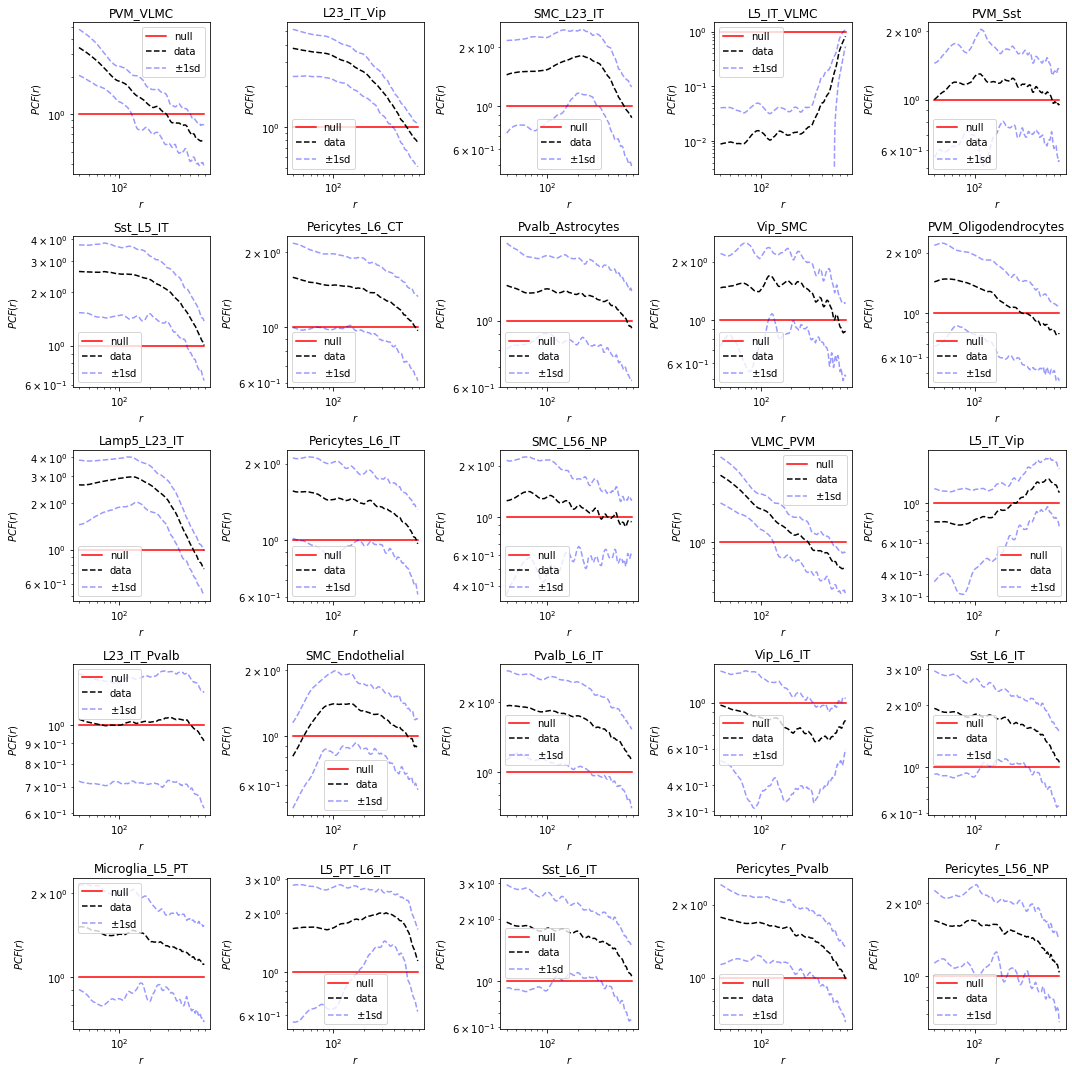

In [25]:
n_show = 25
n_cols = 5
n_rows = int(np.ceil(n_show / n_cols))

ref_dist = 100

radii = results_mu.index.values

figsize = (n_cols * 3,
           n_rows * 3)

fig,ax = plt.subplots(n_cols,
                      n_rows,
                      figsize = figsize)
ax = ax.flatten()

theo = np.ones(radii.shape[0])

cell_types = np.random.choice(results_mu.columns,n_show)

for k,ct in enumerate(cell_types):

    nz = results_mu[ct].values > 0

    ut.plot_results(ax[k],
                    x_vals = radii[nz],
                    obs = results_mu[ct].values[nz],
                    std = results_sd[ct].values[nz],
                    theo = theo[nz],
                    )

    ax[k].set_xscale("log")
    ax[k].set_yscale("log")
    ax[k].set_title(ct)
    
    ax[k].set_xlabel(r"$r$")
    ax[k].set_ylabel(r"$PCF(r)$")

    
fig.tight_layout()
plt.show()

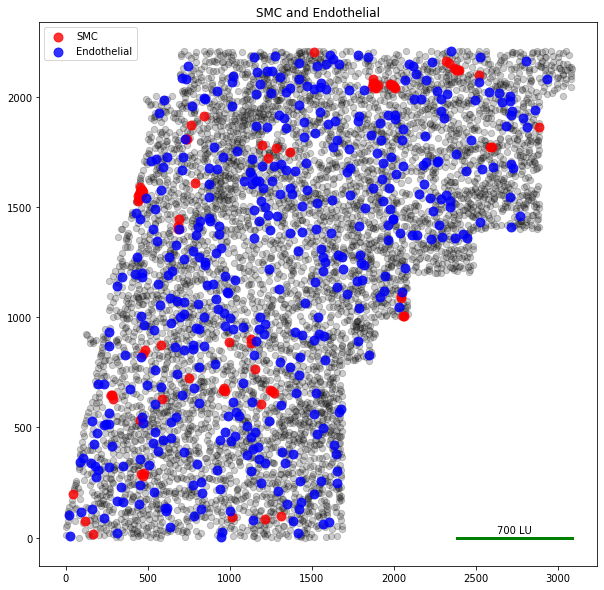

In [22]:
visualize_type_1 = "SMC"
visualize_type_2 = "Endothelial"

selected = [visualize_type_1,visualize_type_2]

visualize_sample = 4

fk = list(data.keys())[visualize_sample]
crd = data[fk].crd
sel_1 = data[fk].types == visualize_type_1
sel_2 = data[fk].types == visualize_type_2


fig,ax = plt.subplots(1,
                      1,
                      figsize = (10,10))

ut.visualize_types(ax,
                  crd,
                  labels = data[fk].types,
                  selected = selected,
                  cmap = "one_two",
                  reference_distance = 700,
                 )
ax.set_title("{} and {}".format(visualize_type_1,
                                visualize_type_2))

plt.show()